# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [5]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [6]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [7]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [8]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [9]:
pbp_data.head()

index            id        offense offense_conference           defense  \
0      0  322430009013  Arizona State             Pac-12  Northern Arizona   
1      1  322430009007  Arizona State             Pac-12  Northern Arizona   
2      2  322430009008  Arizona State             Pac-12  Northern Arizona   
3      3  322430009009  Arizona State             Pac-12  Northern Arizona   
4      4  322430009011  Arizona State             Pac-12  Northern Arizona   

  defense_conference           home              away  offense_score  \
0                NaN  Arizona State  Northern Arizona              7   
1                NaN  Arizona State  Northern Arizona              0   
2                NaN  Arizona State  Northern Arizona              0   
3                NaN  Arizona State  Northern Arizona              0   
4                NaN  Arizona State  Northern Arizona              6   

   defense_score  ...  clock.seconds  yard_line  down  distance  yards_gained  \
0              0  ...             26         35    -1      -1.0            15   
1              0  ...             27         72     1      10.0             0   
2              0  ...             18         72     2      10.0             3   
3              0  ...             45         75     3       7.0            16   
4              0  ...             26         91     1       9.0             9   

           play_type                                          play_text  \
0            Kickoff  Alex Garoutte kickoff for 65 yards returned by...   
1  Pass Incompletion       Taylor Kelly pass incomplete to Chris Coyle.   
2    Pass Completion  Taylor Kelly pass complete to D.J. Foster for ...   
3    Pass Completion  Taylor Kelly pass complete to Chris Coyle for ...   
4               Rush  Cameron Marshall rush for 9 yards for a TOUCHD...   

        ppa  year     EqPPP  
0       NaN  2012  0.000000  
1 -0.512082  2012  0.000000  
2 -0.220409  2012  0.254253  
3  1.072268  2012  1.855460  
4       NaN  2012  1.648449  

[5 rows x 23 columns]

In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
pbp_data.head()

index            id        offense offense_conference           defense  \
0      0  322430009013  Arizona State             Pac-12  Northern Arizona   
1      1  322430009007  Arizona State             Pac-12  Northern Arizona   
2      2  322430009008  Arizona State             Pac-12  Northern Arizona   
3      3  322430009009  Arizona State             Pac-12  Northern Arizona   
4      4  322430009011  Arizona State             Pac-12  Northern Arizona   

  defense_conference           home              away  offense_score  \
0                NaN  Arizona State  Northern Arizona              7   
1                NaN  Arizona State  Northern Arizona              0   
2                NaN  Arizona State  Northern Arizona              0   
3                NaN  Arizona State  Northern Arizona              0   
4                NaN  Arizona State  Northern Arizona              6   

   defense_score  ...  down  distance  yards_gained          play_type  \
0              0  ...    -1      -1.0            15            Kickoff   
1              0  ...     1      10.0             0  Pass Incompletion   
2              0  ...     2      10.0             3    Pass Completion   
3              0  ...     3       7.0            16    Pass Completion   
4              0  ...     1       9.0             9               Rush   

                                           play_text       ppa  year  \
0  Alex Garoutte kickoff for 65 yards returned by...       NaN  2012   
1       Taylor Kelly pass incomplete to Chris Coyle. -0.512082  2012   
2  Taylor Kelly pass complete to D.J. Foster for ... -0.220409  2012   
3  Taylor Kelly pass complete to Chris Coyle for ...  1.072268  2012   
4  Cameron Marshall rush for 9 yards for a TOUCHD...       NaN  2012   

      EqPPP play_explosive play_successful  
0  0.000000          False           False  
1  0.000000          False           False  
2  0.254253          False           False  
3  1.855460           True            True  
4  1.648449          False            True  

[5 rows x 25 columns]

In [12]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: kickoff_plays.yards_gained[x.Index],axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = pt_tmp.values
        punt_distance["Return"] = punt_distance.apply(lambda x: punt_plays.yards_gained[x.Index],axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    #return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0       Virginia    2018  401013183  31.0     -3.0        0.875665  0.396825   
1  Virginia Tech    2018  401013183  34.0      3.0        0.124335  0.368421   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.111111  6.507937  0.930578  ...    0.124959      -0.040309     -0.002715   
1  0.078947  5.513158  0.805619  ...   -0.124959       0.040309      0.002715   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0            0.0             0.166667    0.119048          0.119048   
1            0.0            -0.166667   -0.119048         -0.119048   

   FGEffDiff       5FR   5FRDiff  
0   0.333333  5.070568  0.141137  
1  -0.333333  4.929432 -0.141137  

[2 rows x 53 columns]

In [13]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

Team       Eff      Expl    FinDrv  FldPos    Trnovr       5FR  \
0       Virginia  5.142022  5.050452  5.386628    4.46  5.017309  5.070568   
1  Virginia Tech  4.857978  4.949548  4.613372    5.54  4.982691  4.929432   

    5FRDiff  
0  0.141137  
1 -0.141137

In [14]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 3224500

[81/5670] Updated 5FR Margin for game_id 322522440.
[82/5670] Updating 5FR Margin for game_id 322522483...
[82/5670] Updated 5FR Margin for game_id 322522483.
[83/5670] Updating 5FR Margin for game_id 322522579...
[83/5670] Updated 5FR Margin for game_id 322522579.
[84/5670] Updating 5FR Margin for game_id 322522633...
[84/5670] Updated 5FR Margin for game_id 322522633.
[85/5670] Updating 5FR Margin for game_id 322522653...
[85/5670] Updated 5FR Margin for game_id 322522653.
[86/5670] Updating 5FR Margin for game_id 322522751...
[86/5670] Updated 5FR Margin for game_id 322522751.
[87/5670] Updating 5FR Margin for game_id 322570058...
[87/5670] Updated 5FR Margin for game_id 322570058.
[88/5670] Updating 5FR Margin for game_id 322582439...
[88/5670] Updated 5FR Margin for game_id 322582439.
[89/5670] Updating 5FR Margin for game_id 322590002...
[89/5670] Updated 5FR Margin for game_id 322590002.
[90/5670] Updating 5FR Margin for game_id 322590008...
[90/5670] Updated 5FR Margin for game

[158/5670] Updated 5FR Margin for game_id 322660202.
[159/5670] Updating 5FR Margin for game_id 322660213...
[159/5670] Updated 5FR Margin for game_id 322660213.
[160/5670] Updating 5FR Margin for game_id 322660242...
[160/5670] Updated 5FR Margin for game_id 322660242.
[161/5670] Updating 5FR Margin for game_id 322660249...
[161/5670] Updated 5FR Margin for game_id 322660249.
[162/5670] Updating 5FR Margin for game_id 322660259...
[162/5670] Updated 5FR Margin for game_id 322660259.
[163/5670] Updating 5FR Margin for game_id 322660265...
[163/5670] Updated 5FR Margin for game_id 322660265.
[164/5670] Updating 5FR Margin for game_id 322660275...
[164/5670] Updated 5FR Margin for game_id 322660275.
[165/5670] Updating 5FR Margin for game_id 322660277...
[165/5670] Updated 5FR Margin for game_id 322660277.
[166/5670] Updating 5FR Margin for game_id 322660333...
[166/5670] Updated 5FR Margin for game_id 322660333.
[167/5670] Updating 5FR Margin for game_id 322660344...
[167/5670] Updated 

[238/5670] Updated 5FR Margin for game_id 322800084.
[239/5670] Updating 5FR Margin for game_id 322800087...
[239/5670] Updated 5FR Margin for game_id 322800087.
[240/5670] Updating 5FR Margin for game_id 322800096...
[240/5670] Updated 5FR Margin for game_id 322800096.
[241/5670] Updating 5FR Margin for game_id 322800120...
[241/5670] Updated 5FR Margin for game_id 322800120.
[242/5670] Updating 5FR Margin for game_id 322800142...
[242/5670] Updated 5FR Margin for game_id 322800142.
[243/5670] Updating 5FR Margin for game_id 322800145...
[243/5670] Updated 5FR Margin for game_id 322800145.
[244/5670] Updating 5FR Margin for game_id 322800150...
[244/5670] Updated 5FR Margin for game_id 322800150.
[245/5670] Updating 5FR Margin for game_id 322800152...
[245/5670] Updated 5FR Margin for game_id 322800152.
[246/5670] Updating 5FR Margin for game_id 322800153...
[246/5670] Updated 5FR Margin for game_id 322800153.
[247/5670] Updating 5FR Margin for game_id 322800164...
[247/5670] Updated 

[316/5670] Updated 5FR Margin for game_id 322870349.
[317/5670] Updating 5FR Margin for game_id 322872032...
[317/5670] Updated 5FR Margin for game_id 322872032.
[318/5670] Updating 5FR Margin for game_id 322872050...
[318/5670] Updated 5FR Margin for game_id 322872050.
[319/5670] Updating 5FR Margin for game_id 322872116...
[319/5670] Updated 5FR Margin for game_id 322872116.
[320/5670] Updating 5FR Margin for game_id 322872199...
[320/5670] Updated 5FR Margin for game_id 322872199.
[321/5670] Updating 5FR Margin for game_id 322872229...
[321/5670] Updated 5FR Margin for game_id 322872229.
[322/5670] Updating 5FR Margin for game_id 322872305...
[322/5670] Updated 5FR Margin for game_id 322872305.
[323/5670] Updating 5FR Margin for game_id 322872348...
[323/5670] Updated 5FR Margin for game_id 322872348.
[324/5670] Updating 5FR Margin for game_id 322872390...
[324/5670] Updated 5FR Margin for game_id 322872390.
[325/5670] Updating 5FR Margin for game_id 322872433...
[325/5670] Updated 

[395/5670] Updated 5FR Margin for game_id 323010023.
[396/5670] Updating 5FR Margin for game_id 323010024...
[396/5670] Updated 5FR Margin for game_id 323010024.
[397/5670] Updating 5FR Margin for game_id 323010036...
[397/5670] Updated 5FR Margin for game_id 323010036.
[398/5670] Updating 5FR Margin for game_id 323010052...
[398/5670] Updated 5FR Margin for game_id 323010052.
[399/5670] Updating 5FR Margin for game_id 323010058...
[399/5670] Updated 5FR Margin for game_id 323010058.
[400/5670] Updating 5FR Margin for game_id 323010059...
[400/5670] Updated 5FR Margin for game_id 323010059.
[401/5670] Updating 5FR Margin for game_id 323010061...
[401/5670] Updated 5FR Margin for game_id 323010061.
[402/5670] Updating 5FR Margin for game_id 323010066...
[402/5670] Updated 5FR Margin for game_id 323010066.
[403/5670] Updating 5FR Margin for game_id 323010077...
[403/5670] Updated 5FR Margin for game_id 323010077.
[404/5670] Updating 5FR Margin for game_id 323010103...
[404/5670] Updated 

[471/5670] Updated 5FR Margin for game_id 323080194.
[472/5670] Updating 5FR Margin for game_id 323080204...
[472/5670] Updated 5FR Margin for game_id 323080204.
[473/5670] Updating 5FR Margin for game_id 323080239...
[473/5670] Updated 5FR Margin for game_id 323080239.
[474/5670] Updating 5FR Margin for game_id 323080249...
[474/5670] Updated 5FR Margin for game_id 323080249.
[475/5670] Updating 5FR Margin for game_id 323080254...
[475/5670] Updated 5FR Margin for game_id 323080254.
[476/5670] Updating 5FR Margin for game_id 323080276...
[476/5670] Updated 5FR Margin for game_id 323080276.
[477/5670] Updating 5FR Margin for game_id 323080277...
[477/5670] Updated 5FR Margin for game_id 323080277.
[478/5670] Updating 5FR Margin for game_id 323080278...
[478/5670] Updated 5FR Margin for game_id 323080278.
[479/5670] Updating 5FR Margin for game_id 323080328...
[479/5670] Updated 5FR Margin for game_id 323080328.
[480/5670] Updating 5FR Margin for game_id 323080344...
[480/5670] Updated 

[548/5670] Updated 5FR Margin for game_id 323152628.
[549/5670] Updating 5FR Margin for game_id 323152633...
[549/5670] Updated 5FR Margin for game_id 323152633.
[550/5670] Updating 5FR Margin for game_id 323152638...
[550/5670] Updated 5FR Margin for game_id 323152638.
[551/5670] Updating 5FR Margin for game_id 323152641...
[551/5670] Updated 5FR Margin for game_id 323152641.
[552/5670] Updating 5FR Margin for game_id 323152653...
[552/5670] Updated 5FR Margin for game_id 323152653.
[553/5670] Updating 5FR Margin for game_id 323192050...
[553/5670] Updated 5FR Margin for game_id 323192050.
[554/5670] Updating 5FR Margin for game_id 323192459...
[554/5670] Updated 5FR Margin for game_id 323192459.
[555/5670] Updating 5FR Margin for game_id 323200258...
[555/5670] Updated 5FR Margin for game_id 323200258.
[556/5670] Updating 5FR Margin for game_id 323212005...
[556/5670] Updated 5FR Margin for game_id 323212005.
[557/5670] Updating 5FR Margin for game_id 323212226...
[557/5670] Updated 

[630/5670] Updated 5FR Margin for game_id 323290097.
[631/5670] Updating 5FR Margin for game_id 323290098...
[631/5670] Updated 5FR Margin for game_id 323290098.
[632/5670] Updating 5FR Margin for game_id 323290135...
[632/5670] Updated 5FR Margin for game_id 323290135.
[633/5670] Updating 5FR Margin for game_id 323290145...
[633/5670] Updated 5FR Margin for game_id 323290145.
[634/5670] Updating 5FR Margin for game_id 323290150...
[634/5670] Updated 5FR Margin for game_id 323290150.
[635/5670] Updating 5FR Margin for game_id 323290152...
[635/5670] Updated 5FR Margin for game_id 323290152.
[636/5670] Updating 5FR Margin for game_id 323290153...
[636/5670] Updated 5FR Margin for game_id 323290153.
[637/5670] Updating 5FR Margin for game_id 323290154...
[637/5670] Updated 5FR Margin for game_id 323290154.
[638/5670] Updating 5FR Margin for game_id 323290166...
[638/5670] Updated 5FR Margin for game_id 323290166.
[639/5670] Updating 5FR Margin for game_id 323290194...
[639/5670] Updated 

[709/5670] Updated 5FR Margin for game_id 332430213.
[710/5670] Updating 5FR Margin for game_id 332430228...
[710/5670] Updated 5FR Margin for game_id 332430228.
[711/5670] Updating 5FR Margin for game_id 332430245...
[711/5670] Updated 5FR Margin for game_id 332430245.
[712/5670] Updating 5FR Margin for game_id 332430251...
[712/5670] Updated 5FR Margin for game_id 332430251.
[713/5670] Updating 5FR Margin for game_id 332430258...
[713/5670] Updated 5FR Margin for game_id 332430258.
[714/5670] Updating 5FR Margin for game_id 332430259...
[714/5670] Updated 5FR Margin for game_id 332430259.
[715/5670] Updating 5FR Margin for game_id 332430264...
[715/5670] Updated 5FR Margin for game_id 332430264.
[716/5670] Updating 5FR Margin for game_id 332430275...
[716/5670] Updated 5FR Margin for game_id 332430275.
[717/5670] Updating 5FR Margin for game_id 332430276...
[717/5670] Updated 5FR Margin for game_id 332430276.
[718/5670] Updating 5FR Margin for game_id 332432132...
[718/5670] Updated 

[787/5670] Updated 5FR Margin for game_id 332570151.
[788/5670] Updating 5FR Margin for game_id 332570154...
[788/5670] Updated 5FR Margin for game_id 332570154.
[789/5670] Updating 5FR Margin for game_id 332570158...
[789/5670] Updated 5FR Margin for game_id 332570158.
[790/5670] Updating 5FR Margin for game_id 332570164...
[790/5670] Updated 5FR Margin for game_id 332570164.
[791/5670] Updating 5FR Margin for game_id 332570166...
[791/5670] Updated 5FR Margin for game_id 332570166.
[792/5670] Updating 5FR Margin for game_id 332570195...
[792/5670] Updated 5FR Margin for game_id 332570195.
[793/5670] Updating 5FR Margin for game_id 332570201...
[793/5670] Updated 5FR Margin for game_id 332570201.
[794/5670] Updating 5FR Margin for game_id 332570213...
[794/5670] Updated 5FR Margin for game_id 332570213.
[795/5670] Updating 5FR Margin for game_id 332570221...
[795/5670] Updated 5FR Margin for game_id 332570221.
[796/5670] Updating 5FR Margin for game_id 332570242...
[796/5670] Updated 

[865/5670] Updated 5FR Margin for game_id 332710096.
[866/5670] Updating 5FR Margin for game_id 332710098...
[866/5670] Updated 5FR Margin for game_id 332710098.
[867/5670] Updating 5FR Margin for game_id 332710103...
[867/5670] Updated 5FR Margin for game_id 332710103.
[868/5670] Updating 5FR Margin for game_id 332710135...
[868/5670] Updated 5FR Margin for game_id 332710135.
[869/5670] Updating 5FR Margin for game_id 332710142...
[869/5670] Updated 5FR Margin for game_id 332710142.
[870/5670] Updating 5FR Margin for game_id 332710150...
[870/5670] Updated 5FR Margin for game_id 332710150.
[871/5670] Updating 5FR Margin for game_id 332710152...
[871/5670] Updated 5FR Margin for game_id 332710152.
[872/5670] Updating 5FR Margin for game_id 332710153...
[872/5670] Updated 5FR Margin for game_id 332710153.
[873/5670] Updating 5FR Margin for game_id 332710166...
[873/5670] Updated 5FR Margin for game_id 332710166.
[874/5670] Updating 5FR Margin for game_id 332710167...
[874/5670] Updated 

[947/5670] Updated 5FR Margin for game_id 332782567.
[948/5670] Updating 5FR Margin for game_id 332782572...
[948/5670] Updated 5FR Margin for game_id 332782572.
[949/5670] Updating 5FR Margin for game_id 332782579...
[949/5670] Updated 5FR Margin for game_id 332782579.
[950/5670] Updating 5FR Margin for game_id 332782633...
[950/5670] Updated 5FR Margin for game_id 332782633.
[951/5670] Updating 5FR Margin for game_id 332782638...
[951/5670] Updated 5FR Margin for game_id 332782638.
[952/5670] Updating 5FR Margin for game_id 332782649...
[952/5670] Updated 5FR Margin for game_id 332782649.
[953/5670] Updating 5FR Margin for game_id 332782653...
[953/5670] Updated 5FR Margin for game_id 332782653.
[954/5670] Updating 5FR Margin for game_id 332782655...
[954/5670] Updated 5FR Margin for game_id 332782655.
[955/5670] Updating 5FR Margin for game_id 332830030...
[955/5670] Updated 5FR Margin for game_id 332830030.
[956/5670] Updating 5FR Margin for game_id 332830097...
[956/5670] Updated 

[1025/5670] Updated 5FR Margin for game_id 332920194.
[1026/5670] Updating 5FR Margin for game_id 332920197...
[1026/5670] Updated 5FR Margin for game_id 332920197.
[1027/5670] Updating 5FR Margin for game_id 332920218...
[1027/5670] Updated 5FR Margin for game_id 332920218.
[1028/5670] Updating 5FR Margin for game_id 332920221...
[1028/5670] Updated 5FR Margin for game_id 332920221.
[1029/5670] Updating 5FR Margin for game_id 332920228...
[1029/5670] Updated 5FR Margin for game_id 332920228.
[1030/5670] Updating 5FR Margin for game_id 332920235...
[1030/5670] Updated 5FR Margin for game_id 332920235.
[1031/5670] Updating 5FR Margin for game_id 332920238...
[1031/5670] Updated 5FR Margin for game_id 332920238.
[1032/5670] Updating 5FR Margin for game_id 332920239...
[1032/5670] Updated 5FR Margin for game_id 332920239.
[1033/5670] Updating 5FR Margin for game_id 332920245...
[1033/5670] Updated 5FR Margin for game_id 332920245.
[1034/5670] Updating 5FR Margin for game_id 332920248...
[

[1100/5670] Updated 5FR Margin for game_id 332992572.
[1101/5670] Updating 5FR Margin for game_id 332992628...
[1101/5670] Updated 5FR Margin for game_id 332992628.
[1102/5670] Updating 5FR Margin for game_id 332992636...
[1102/5670] Updated 5FR Margin for game_id 332992636.
[1103/5670] Updating 5FR Margin for game_id 332992655...
[1103/5670] Updated 5FR Margin for game_id 332992655.
[1104/5670] Updating 5FR Margin for game_id 333030235...
[1104/5670] Updated 5FR Margin for game_id 333030235.
[1105/5670] Updating 5FR Margin for game_id 333040248...
[1105/5670] Updated 5FR Margin for game_id 333040248.
[1106/5670] Updating 5FR Margin for game_id 333040249...
[1106/5670] Updated 5FR Margin for game_id 333040249.
[1107/5670] Updating 5FR Margin for game_id 333040265...
[1107/5670] Updated 5FR Margin for game_id 333040265.
[1108/5670] Updating 5FR Margin for game_id 333042653...
[1108/5670] Updated 5FR Margin for game_id 333042653.
[1109/5670] Updating 5FR Margin for game_id 333050204...
[

[1174/5670] Updated 5FR Margin for game_id 333130151.
[1175/5670] Updating 5FR Margin for game_id 333130153...
[1175/5670] Updated 5FR Margin for game_id 333130153.
[1176/5670] Updating 5FR Margin for game_id 333130154...
[1176/5670] Updated 5FR Margin for game_id 333130154.
[1177/5670] Updating 5FR Margin for game_id 333130166...
[1177/5670] Updated 5FR Margin for game_id 333130166.
[1178/5670] Updating 5FR Margin for game_id 333130197...
[1178/5670] Updated 5FR Margin for game_id 333130197.
[1179/5670] Updating 5FR Margin for game_id 333130221...
[1179/5670] Updated 5FR Margin for game_id 333130221.
[1180/5670] Updating 5FR Margin for game_id 333130245...
[1180/5670] Updated 5FR Margin for game_id 333130245.
[1181/5670] Updating 5FR Margin for game_id 333130249...
[1181/5670] Updated 5FR Margin for game_id 333130249.
[1182/5670] Updating 5FR Margin for game_id 333130254...
[1182/5670] Updated 5FR Margin for game_id 333130254.
[1183/5670] Updating 5FR Margin for game_id 333130264...
[

[1249/5670] Updated 5FR Margin for game_id 333202572.
[1250/5670] Updating 5FR Margin for game_id 333202579...
[1250/5670] Updated 5FR Margin for game_id 333202579.
[1251/5670] Updating 5FR Margin for game_id 333202638...
[1251/5670] Updated 5FR Margin for game_id 333202638.
[1252/5670] Updating 5FR Margin for game_id 333202711...
[1252/5670] Updated 5FR Margin for game_id 333202711.
[1253/5670] Updating 5FR Margin for game_id 333230193...
[1253/5670] Updated 5FR Margin for game_id 333230193.
[1254/5670] Updating 5FR Margin for game_id 333230195...
[1254/5670] Updated 5FR Margin for game_id 333230195.
[1255/5670] Updating 5FR Margin for game_id 333242649...
[1255/5670] Updated 5FR Margin for game_id 333242649.
[1256/5670] Updating 5FR Margin for game_id 333250005...
[1256/5670] Updated 5FR Margin for game_id 333250005.
[1257/5670] Updating 5FR Margin for game_id 333252005...
[1257/5670] Updated 5FR Margin for game_id 333252005.
[1258/5670] Updating 5FR Margin for game_id 333252116...
[

[1326/5670] Updated 5FR Margin for game_id 333332653.
[1327/5670] Updating 5FR Margin for game_id 333340002...
[1327/5670] Updated 5FR Margin for game_id 333340002.
[1328/5670] Updating 5FR Margin for game_id 333340005...
[1328/5670] Updated 5FR Margin for game_id 333340005.
[1329/5670] Updating 5FR Margin for game_id 333340009...
[1329/5670] Updated 5FR Margin for game_id 333340009.
[1330/5670] Updating 5FR Margin for game_id 333340024...
[1330/5670] Updated 5FR Margin for game_id 333340024.
[1331/5670] Updating 5FR Margin for game_id 333340030...
[1331/5670] Updated 5FR Margin for game_id 333340030.
[1332/5670] Updating 5FR Margin for game_id 333340036...
[1332/5670] Updated 5FR Margin for game_id 333340036.
[1333/5670] Updating 5FR Margin for game_id 333340041...
[1333/5670] Updated 5FR Margin for game_id 333340041.
[1334/5670] Updating 5FR Margin for game_id 333340057...
[1334/5670] Updated 5FR Margin for game_id 333340057.
[1335/5670] Updating 5FR Margin for game_id 333340059...
[

[1404/5670] Updated 5FR Margin for game_id 400547670.
[1405/5670] Updating 5FR Margin for game_id 400547671...
[1405/5670] Updated 5FR Margin for game_id 400547671.
[1406/5670] Updating 5FR Margin for game_id 400547673...
[1406/5670] Updated 5FR Margin for game_id 400547673.
[1407/5670] Updating 5FR Margin for game_id 400547674...
[1407/5670] Updated 5FR Margin for game_id 400547674.
[1408/5670] Updating 5FR Margin for game_id 400547675...
[1408/5670] Updated 5FR Margin for game_id 400547675.
[1409/5670] Updating 5FR Margin for game_id 400547676...
[1409/5670] Updated 5FR Margin for game_id 400547676.
[1410/5670] Updating 5FR Margin for game_id 400547677...
[1410/5670] Updated 5FR Margin for game_id 400547677.
[1411/5670] Updating 5FR Margin for game_id 400547678...
[1411/5670] Updated 5FR Margin for game_id 400547678.
[1412/5670] Updating 5FR Margin for game_id 400547679...
[1412/5670] Updated 5FR Margin for game_id 400547679.
[1413/5670] Updating 5FR Margin for game_id 400547680...
[

[1481/5670] Updated 5FR Margin for game_id 400547754.
[1482/5670] Updating 5FR Margin for game_id 400547755...
[1482/5670] Updated 5FR Margin for game_id 400547755.
[1483/5670] Updating 5FR Margin for game_id 400547756...
[1483/5670] Updated 5FR Margin for game_id 400547756.
[1484/5670] Updating 5FR Margin for game_id 400547757...
[1484/5670] Updated 5FR Margin for game_id 400547757.
[1485/5670] Updating 5FR Margin for game_id 400547758...
[1485/5670] Updated 5FR Margin for game_id 400547758.
[1486/5670] Updating 5FR Margin for game_id 400547759...
[1486/5670] Updated 5FR Margin for game_id 400547759.
[1487/5670] Updating 5FR Margin for game_id 400547760...
[1487/5670] Updated 5FR Margin for game_id 400547760.
[1488/5670] Updating 5FR Margin for game_id 400547761...
[1488/5670] Updated 5FR Margin for game_id 400547761.
[1489/5670] Updating 5FR Margin for game_id 400547762...
[1489/5670] Updated 5FR Margin for game_id 400547762.
[1490/5670] Updating 5FR Margin for game_id 400547764...
[

[1556/5670] Updated 5FR Margin for game_id 400547848.
[1557/5670] Updating 5FR Margin for game_id 400547849...
[1557/5670] Updated 5FR Margin for game_id 400547849.
[1558/5670] Updating 5FR Margin for game_id 400547850...
[1558/5670] Updated 5FR Margin for game_id 400547850.
[1559/5670] Updating 5FR Margin for game_id 400547851...
[1559/5670] Updated 5FR Margin for game_id 400547851.
[1560/5670] Updating 5FR Margin for game_id 400547852...
[1560/5670] Updated 5FR Margin for game_id 400547852.
[1561/5670] Updating 5FR Margin for game_id 400547853...
[1561/5670] Updated 5FR Margin for game_id 400547853.
[1562/5670] Updating 5FR Margin for game_id 400547855...
[1562/5670] Updated 5FR Margin for game_id 400547855.
[1563/5670] Updating 5FR Margin for game_id 400547856...
[1563/5670] Updated 5FR Margin for game_id 400547856.
[1564/5670] Updating 5FR Margin for game_id 400547857...
[1564/5670] Updated 5FR Margin for game_id 400547857.
[1565/5670] Updating 5FR Margin for game_id 400547858...
[

[1635/5670] Updated 5FR Margin for game_id 400547932.
[1636/5670] Updating 5FR Margin for game_id 400547933...
[1636/5670] Updated 5FR Margin for game_id 400547933.
[1637/5670] Updating 5FR Margin for game_id 400547934...
[1637/5670] Updated 5FR Margin for game_id 400547934.
[1638/5670] Updating 5FR Margin for game_id 400547935...
[1638/5670] Updated 5FR Margin for game_id 400547935.
[1639/5670] Updating 5FR Margin for game_id 400547937...
[1639/5670] Updated 5FR Margin for game_id 400547937.
[1640/5670] Updating 5FR Margin for game_id 400547938...
[1640/5670] Updated 5FR Margin for game_id 400547938.
[1641/5670] Updating 5FR Margin for game_id 400547939...
[1641/5670] Updated 5FR Margin for game_id 400547939.
[1642/5670] Updating 5FR Margin for game_id 400547940...
[1642/5670] Updated 5FR Margin for game_id 400547940.
[1643/5670] Updating 5FR Margin for game_id 400547941...
[1643/5670] Updated 5FR Margin for game_id 400547941.
[1644/5670] Updating 5FR Margin for game_id 400547942...
[

[1714/5670] Updated 5FR Margin for game_id 400548026.
[1715/5670] Updating 5FR Margin for game_id 400548027...
[1715/5670] Updated 5FR Margin for game_id 400548027.
[1716/5670] Updating 5FR Margin for game_id 400548029...
[1716/5670] Updated 5FR Margin for game_id 400548029.
[1717/5670] Updating 5FR Margin for game_id 400548031...
[1717/5670] Updated 5FR Margin for game_id 400548031.
[1718/5670] Updating 5FR Margin for game_id 400548032...
[1718/5670] Updated 5FR Margin for game_id 400548032.
[1719/5670] Updating 5FR Margin for game_id 400548033...
[1719/5670] Updated 5FR Margin for game_id 400548033.
[1720/5670] Updating 5FR Margin for game_id 400548034...
[1720/5670] Updated 5FR Margin for game_id 400548034.
[1721/5670] Updating 5FR Margin for game_id 400548035...
[1721/5670] Updated 5FR Margin for game_id 400548035.
[1722/5670] Updating 5FR Margin for game_id 400548036...
[1722/5670] Updated 5FR Margin for game_id 400548036.
[1723/5670] Updating 5FR Margin for game_id 400548037...
[

[1793/5670] Updated 5FR Margin for game_id 400548128.
[1794/5670] Updating 5FR Margin for game_id 400548129...
[1794/5670] Updated 5FR Margin for game_id 400548129.
[1795/5670] Updating 5FR Margin for game_id 400548130...
[1795/5670] Updated 5FR Margin for game_id 400548130.
[1796/5670] Updating 5FR Margin for game_id 400548131...
[1796/5670] Updated 5FR Margin for game_id 400548131.
[1797/5670] Updating 5FR Margin for game_id 400548132...
[1797/5670] Updated 5FR Margin for game_id 400548132.
[1798/5670] Updating 5FR Margin for game_id 400548133...
[1798/5670] Updated 5FR Margin for game_id 400548133.
[1799/5670] Updating 5FR Margin for game_id 400548134...
[1799/5670] Updated 5FR Margin for game_id 400548134.
[1800/5670] Updating 5FR Margin for game_id 400548135...
[1800/5670] Updated 5FR Margin for game_id 400548135.
[1801/5670] Updating 5FR Margin for game_id 400548136...
[1801/5670] Updated 5FR Margin for game_id 400548136.
[1802/5670] Updating 5FR Margin for game_id 400548137...
[

[1873/5670] Updated 5FR Margin for game_id 400548221.
[1874/5670] Updating 5FR Margin for game_id 400548222...
[1874/5670] Updated 5FR Margin for game_id 400548222.
[1875/5670] Updating 5FR Margin for game_id 400548224...
[1875/5670] Updated 5FR Margin for game_id 400548224.
[1876/5670] Updating 5FR Margin for game_id 400548225...
[1876/5670] Updated 5FR Margin for game_id 400548225.
[1877/5670] Updating 5FR Margin for game_id 400548226...
[1877/5670] Updated 5FR Margin for game_id 400548226.
[1878/5670] Updating 5FR Margin for game_id 400548228...
[1878/5670] Updated 5FR Margin for game_id 400548228.
[1879/5670] Updating 5FR Margin for game_id 400548229...
[1879/5670] Updated 5FR Margin for game_id 400548229.
[1880/5670] Updating 5FR Margin for game_id 400548230...
[1880/5670] Updated 5FR Margin for game_id 400548230.
[1881/5670] Updating 5FR Margin for game_id 400548231...
[1881/5670] Updated 5FR Margin for game_id 400548231.
[1882/5670] Updating 5FR Margin for game_id 400548232...
[

[1948/5670] Updated 5FR Margin for game_id 400548308.
[1949/5670] Updating 5FR Margin for game_id 400548309...
[1949/5670] Updated 5FR Margin for game_id 400548309.
[1950/5670] Updating 5FR Margin for game_id 400548310...
[1950/5670] Updated 5FR Margin for game_id 400548310.
[1951/5670] Updating 5FR Margin for game_id 400548311...
[1951/5670] Updated 5FR Margin for game_id 400548311.
[1952/5670] Updating 5FR Margin for game_id 400548312...
[1952/5670] Updated 5FR Margin for game_id 400548312.
[1953/5670] Updating 5FR Margin for game_id 400548313...
[1953/5670] Updated 5FR Margin for game_id 400548313.
[1954/5670] Updating 5FR Margin for game_id 400548314...
[1954/5670] Updated 5FR Margin for game_id 400548314.
[1955/5670] Updating 5FR Margin for game_id 400548315...
[1955/5670] Updated 5FR Margin for game_id 400548315.
[1956/5670] Updating 5FR Margin for game_id 400548316...
[1956/5670] Updated 5FR Margin for game_id 400548316.
[1957/5670] Updating 5FR Margin for game_id 400548317...
[

[2026/5670] Updated 5FR Margin for game_id 400548398.
[2027/5670] Updating 5FR Margin for game_id 400548402...
[2027/5670] Updated 5FR Margin for game_id 400548402.
[2028/5670] Updating 5FR Margin for game_id 400548412...
[2028/5670] Updated 5FR Margin for game_id 400548412.
[2029/5670] Updating 5FR Margin for game_id 400548414...
[2029/5670] Updated 5FR Margin for game_id 400548414.
[2030/5670] Updating 5FR Margin for game_id 400548417...
[2030/5670] Updated 5FR Margin for game_id 400548417.
[2031/5670] Updating 5FR Margin for game_id 400548418...
[2031/5670] Updated 5FR Margin for game_id 400548418.
[2032/5670] Updating 5FR Margin for game_id 400548419...
[2032/5670] Updated 5FR Margin for game_id 400548419.
[2033/5670] Updating 5FR Margin for game_id 400548420...
[2033/5670] Updated 5FR Margin for game_id 400548420.
[2034/5670] Updating 5FR Margin for game_id 400548421...
[2034/5670] Updated 5FR Margin for game_id 400548421.
[2035/5670] Updating 5FR Margin for game_id 400548423...
[

[2107/5670] Updated 5FR Margin for game_id 400603873.
[2108/5670] Updating 5FR Margin for game_id 400603874...
[2108/5670] Updated 5FR Margin for game_id 400603874.
[2109/5670] Updating 5FR Margin for game_id 400603875...
[2109/5670] Updated 5FR Margin for game_id 400603875.
[2110/5670] Updating 5FR Margin for game_id 400603876...
[2110/5670] Updated 5FR Margin for game_id 400603876.
[2111/5670] Updating 5FR Margin for game_id 400603877...
[2111/5670] Updated 5FR Margin for game_id 400603877.
[2112/5670] Updating 5FR Margin for game_id 400603878...
[2112/5670] Updated 5FR Margin for game_id 400603878.
[2113/5670] Updating 5FR Margin for game_id 400603879...
[2113/5670] Updated 5FR Margin for game_id 400603879.
[2114/5670] Updating 5FR Margin for game_id 400603881...
[2114/5670] Updated 5FR Margin for game_id 400603881.
[2115/5670] Updating 5FR Margin for game_id 400603882...
[2115/5670] Updated 5FR Margin for game_id 400603882.
[2116/5670] Updating 5FR Margin for game_id 400603883...
[

[2182/5670] Updated 5FR Margin for game_id 400756901.
[2183/5670] Updating 5FR Margin for game_id 400756904...
[2183/5670] Updated 5FR Margin for game_id 400756904.
[2184/5670] Updating 5FR Margin for game_id 400756905...
[2184/5670] Updated 5FR Margin for game_id 400756905.
[2185/5670] Updating 5FR Margin for game_id 400756907...
[2185/5670] Updated 5FR Margin for game_id 400756907.
[2186/5670] Updating 5FR Margin for game_id 400756910...
[2186/5670] Updated 5FR Margin for game_id 400756910.
[2187/5670] Updating 5FR Margin for game_id 400756911...
[2187/5670] Updated 5FR Margin for game_id 400756911.
[2188/5670] Updating 5FR Margin for game_id 400756912...
[2188/5670] Updated 5FR Margin for game_id 400756912.
[2189/5670] Updating 5FR Margin for game_id 400756915...
[2189/5670] Updated 5FR Margin for game_id 400756915.
[2190/5670] Updating 5FR Margin for game_id 400756916...
[2190/5670] Updated 5FR Margin for game_id 400756916.
[2191/5670] Updating 5FR Margin for game_id 400756917...
[

[2258/5670] Updated 5FR Margin for game_id 400756990.
[2259/5670] Updating 5FR Margin for game_id 400756991...
[2259/5670] Updated 5FR Margin for game_id 400756991.
[2260/5670] Updating 5FR Margin for game_id 400756992...
[2260/5670] Updated 5FR Margin for game_id 400756992.
[2261/5670] Updating 5FR Margin for game_id 400756993...
[2261/5670] Updated 5FR Margin for game_id 400756993.
[2262/5670] Updating 5FR Margin for game_id 400756994...
[2262/5670] Updated 5FR Margin for game_id 400756994.
[2263/5670] Updating 5FR Margin for game_id 400756995...
[2263/5670] Updated 5FR Margin for game_id 400756995.
[2264/5670] Updating 5FR Margin for game_id 400756996...
[2264/5670] Updated 5FR Margin for game_id 400756996.
[2265/5670] Updating 5FR Margin for game_id 400756997...
[2265/5670] Updated 5FR Margin for game_id 400756997.
[2266/5670] Updating 5FR Margin for game_id 400756998...
[2266/5670] Updated 5FR Margin for game_id 400756998.
[2267/5670] Updating 5FR Margin for game_id 400757015...
[

[2334/5670] Updated 5FR Margin for game_id 400757087.
[2335/5670] Updating 5FR Margin for game_id 400757088...
[2335/5670] Updated 5FR Margin for game_id 400757088.
[2336/5670] Updating 5FR Margin for game_id 400757089...
[2336/5670] Updated 5FR Margin for game_id 400757089.
[2337/5670] Updating 5FR Margin for game_id 400757090...
[2337/5670] Updated 5FR Margin for game_id 400757090.
[2338/5670] Updating 5FR Margin for game_id 400760492...
[2338/5670] Updated 5FR Margin for game_id 400760492.
[2339/5670] Updating 5FR Margin for game_id 400760493...
[2339/5670] Updated 5FR Margin for game_id 400760493.
[2340/5670] Updating 5FR Margin for game_id 400760494...
[2340/5670] Updated 5FR Margin for game_id 400760494.
[2341/5670] Updating 5FR Margin for game_id 400760496...
[2341/5670] Updated 5FR Margin for game_id 400760496.
[2342/5670] Updating 5FR Margin for game_id 400760497...
[2342/5670] Updated 5FR Margin for game_id 400760497.
[2343/5670] Updating 5FR Margin for game_id 400760498...
[

[2408/5670] Updated 5FR Margin for game_id 400763468.
[2409/5670] Updating 5FR Margin for game_id 400763469...
[2409/5670] Updated 5FR Margin for game_id 400763469.
[2410/5670] Updating 5FR Margin for game_id 400763470...
[2410/5670] Updated 5FR Margin for game_id 400763470.
[2411/5670] Updating 5FR Margin for game_id 400763495...
[2411/5670] Updated 5FR Margin for game_id 400763495.
[2412/5670] Updating 5FR Margin for game_id 400763497...
[2412/5670] Updated 5FR Margin for game_id 400763497.
[2413/5670] Updating 5FR Margin for game_id 400763498...
[2413/5670] Updated 5FR Margin for game_id 400763498.
[2414/5670] Updating 5FR Margin for game_id 400763499...
[2414/5670] Updated 5FR Margin for game_id 400763499.
[2415/5670] Updating 5FR Margin for game_id 400763501...
[2415/5670] Updated 5FR Margin for game_id 400763501.
[2416/5670] Updating 5FR Margin for game_id 400763502...
[2416/5670] Updated 5FR Margin for game_id 400763502.
[2417/5670] Updating 5FR Margin for game_id 400763503...
[

[2483/5670] Updated 5FR Margin for game_id 400763571.
[2484/5670] Updating 5FR Margin for game_id 400763572...
[2484/5670] Updated 5FR Margin for game_id 400763572.
[2485/5670] Updating 5FR Margin for game_id 400763573...
[2485/5670] Updated 5FR Margin for game_id 400763573.
[2486/5670] Updating 5FR Margin for game_id 400763574...
[2486/5670] Updated 5FR Margin for game_id 400763574.
[2487/5670] Updating 5FR Margin for game_id 400763575...
[2487/5670] Updated 5FR Margin for game_id 400763575.
[2488/5670] Updating 5FR Margin for game_id 400763576...
[2488/5670] Updated 5FR Margin for game_id 400763576.
[2489/5670] Updating 5FR Margin for game_id 400763577...
[2489/5670] Updated 5FR Margin for game_id 400763577.
[2490/5670] Updating 5FR Margin for game_id 400763578...
[2490/5670] Updated 5FR Margin for game_id 400763578.
[2491/5670] Updating 5FR Margin for game_id 400763579...
[2491/5670] Updated 5FR Margin for game_id 400763579.
[2492/5670] Updating 5FR Margin for game_id 400763580...
[

[2561/5670] Updated 5FR Margin for game_id 400763662.
[2562/5670] Updating 5FR Margin for game_id 400763663...
[2562/5670] Updated 5FR Margin for game_id 400763663.
[2563/5670] Updating 5FR Margin for game_id 400763664...
[2563/5670] Updated 5FR Margin for game_id 400763664.
[2564/5670] Updating 5FR Margin for game_id 400764855...
[2564/5670] Updated 5FR Margin for game_id 400764855.
[2565/5670] Updating 5FR Margin for game_id 400764862...
[2565/5670] Updated 5FR Margin for game_id 400764862.
[2566/5670] Updating 5FR Margin for game_id 400764863...
[2566/5670] Updated 5FR Margin for game_id 400764863.
[2567/5670] Updating 5FR Margin for game_id 400764864...
[2567/5670] Updated 5FR Margin for game_id 400764864.
[2568/5670] Updating 5FR Margin for game_id 400764865...
[2568/5670] Updated 5FR Margin for game_id 400764865.
[2569/5670] Updating 5FR Margin for game_id 400764866...
[2569/5670] Updated 5FR Margin for game_id 400764866.
[2570/5670] Updating 5FR Margin for game_id 400764869...
[

[2635/5670] Updated 5FR Margin for game_id 400787249.
[2636/5670] Updating 5FR Margin for game_id 400787250...
[2636/5670] Updated 5FR Margin for game_id 400787250.
[2637/5670] Updating 5FR Margin for game_id 400787251...
[2637/5670] Updated 5FR Margin for game_id 400787251.
[2638/5670] Updating 5FR Margin for game_id 400787252...
[2638/5670] Updated 5FR Margin for game_id 400787252.
[2639/5670] Updating 5FR Margin for game_id 400787253...
[2639/5670] Updated 5FR Margin for game_id 400787253.
[2640/5670] Updating 5FR Margin for game_id 400787254...
[2640/5670] Updated 5FR Margin for game_id 400787254.
[2641/5670] Updating 5FR Margin for game_id 400787255...
[2641/5670] Updated 5FR Margin for game_id 400787255.
[2642/5670] Updating 5FR Margin for game_id 400787256...
[2642/5670] Updated 5FR Margin for game_id 400787256.
[2643/5670] Updating 5FR Margin for game_id 400787257...
[2643/5670] Updated 5FR Margin for game_id 400787257.
[2644/5670] Updating 5FR Margin for game_id 400787258...
[

[2710/5670] Updated 5FR Margin for game_id 400787344.
[2711/5670] Updating 5FR Margin for game_id 400787346...
[2711/5670] Updated 5FR Margin for game_id 400787346.
[2712/5670] Updating 5FR Margin for game_id 400787347...
[2712/5670] Updated 5FR Margin for game_id 400787347.
[2713/5670] Updating 5FR Margin for game_id 400787348...
[2713/5670] Updated 5FR Margin for game_id 400787348.
[2714/5670] Updating 5FR Margin for game_id 400787349...
[2714/5670] Updated 5FR Margin for game_id 400787349.
[2715/5670] Updating 5FR Margin for game_id 400787350...
[2715/5670] Updated 5FR Margin for game_id 400787350.
[2716/5670] Updating 5FR Margin for game_id 400787351...
[2716/5670] Updated 5FR Margin for game_id 400787351.
[2717/5670] Updating 5FR Margin for game_id 400787352...
[2717/5670] Updated 5FR Margin for game_id 400787352.
[2718/5670] Updating 5FR Margin for game_id 400787353...
[2718/5670] Updated 5FR Margin for game_id 400787353.
[2719/5670] Updating 5FR Margin for game_id 400787354...
[

[2789/5670] Updated 5FR Margin for game_id 400868879.
[2790/5670] Updating 5FR Margin for game_id 400868880...
[2790/5670] Updated 5FR Margin for game_id 400868880.
[2791/5670] Updating 5FR Margin for game_id 400868881...
[2791/5670] Updated 5FR Margin for game_id 400868881.
[2792/5670] Updating 5FR Margin for game_id 400868882...
[2792/5670] Updated 5FR Margin for game_id 400868882.
[2793/5670] Updating 5FR Margin for game_id 400868883...
[2793/5670] Updated 5FR Margin for game_id 400868883.
[2794/5670] Updating 5FR Margin for game_id 400868884...
[2794/5670] Updated 5FR Margin for game_id 400868884.
[2795/5670] Updating 5FR Margin for game_id 400868885...
[2795/5670] Updated 5FR Margin for game_id 400868885.
[2796/5670] Updating 5FR Margin for game_id 400868886...
[2796/5670] Updated 5FR Margin for game_id 400868886.
[2797/5670] Updating 5FR Margin for game_id 400868888...
[2797/5670] Updated 5FR Margin for game_id 400868888.
[2798/5670] Updating 5FR Margin for game_id 400868889...
[

[2866/5670] Updated 5FR Margin for game_id 400869000.
[2867/5670] Updating 5FR Margin for game_id 400869001...
[2867/5670] Updated 5FR Margin for game_id 400869001.
[2868/5670] Updating 5FR Margin for game_id 400869002...
[2868/5670] Updated 5FR Margin for game_id 400869002.
[2869/5670] Updating 5FR Margin for game_id 400869003...
[2869/5670] Updated 5FR Margin for game_id 400869003.
[2870/5670] Updating 5FR Margin for game_id 400869004...
[2870/5670] Updated 5FR Margin for game_id 400869004.
[2871/5670] Updating 5FR Margin for game_id 400869005...
[2871/5670] Updated 5FR Margin for game_id 400869005.
[2872/5670] Updating 5FR Margin for game_id 400869007...
[2872/5670] Updated 5FR Margin for game_id 400869007.
[2873/5670] Updating 5FR Margin for game_id 400869008...
[2873/5670] Updated 5FR Margin for game_id 400869008.
[2874/5670] Updating 5FR Margin for game_id 400869009...
[2874/5670] Updated 5FR Margin for game_id 400869009.
[2875/5670] Updating 5FR Margin for game_id 400869010...
[

[2941/5670] Updated 5FR Margin for game_id 400869108.
[2942/5670] Updating 5FR Margin for game_id 400869109...
[2942/5670] Updated 5FR Margin for game_id 400869109.
[2943/5670] Updating 5FR Margin for game_id 400869110...
[2943/5670] Updated 5FR Margin for game_id 400869110.
[2944/5670] Updating 5FR Margin for game_id 400869111...
[2944/5670] Updated 5FR Margin for game_id 400869111.
[2945/5670] Updating 5FR Margin for game_id 400869112...
[2945/5670] Updated 5FR Margin for game_id 400869112.
[2946/5670] Updating 5FR Margin for game_id 400869113...
[2946/5670] Updated 5FR Margin for game_id 400869113.
[2947/5670] Updating 5FR Margin for game_id 400869117...
[2947/5670] Updated 5FR Margin for game_id 400869117.
[2948/5670] Updating 5FR Margin for game_id 400869118...
[2948/5670] Updated 5FR Margin for game_id 400869118.
[2949/5670] Updating 5FR Margin for game_id 400869119...
[2949/5670] Updated 5FR Margin for game_id 400869119.
[2950/5670] Updating 5FR Margin for game_id 400869120...
[

[3020/5670] Updated 5FR Margin for game_id 400869202.
[3021/5670] Updating 5FR Margin for game_id 400869203...
[3021/5670] Updated 5FR Margin for game_id 400869203.
[3022/5670] Updating 5FR Margin for game_id 400869204...
[3022/5670] Updated 5FR Margin for game_id 400869204.
[3023/5670] Updating 5FR Margin for game_id 400869206...
[3023/5670] Updated 5FR Margin for game_id 400869206.
[3024/5670] Updating 5FR Margin for game_id 400869207...
[3024/5670] Updated 5FR Margin for game_id 400869207.
[3025/5670] Updating 5FR Margin for game_id 400869208...
[3025/5670] Updated 5FR Margin for game_id 400869208.
[3026/5670] Updating 5FR Margin for game_id 400869209...
[3026/5670] Updated 5FR Margin for game_id 400869209.
[3027/5670] Updating 5FR Margin for game_id 400869210...
[3027/5670] Updated 5FR Margin for game_id 400869210.
[3028/5670] Updating 5FR Margin for game_id 400869211...
[3028/5670] Updated 5FR Margin for game_id 400869211.
[3029/5670] Updating 5FR Margin for game_id 400869212...
[

[3101/5670] Updated 5FR Margin for game_id 400869299.
[3102/5670] Updating 5FR Margin for game_id 400869300...
[3102/5670] Updated 5FR Margin for game_id 400869300.
[3103/5670] Updating 5FR Margin for game_id 400869301...
[3103/5670] Updated 5FR Margin for game_id 400869301.
[3104/5670] Updating 5FR Margin for game_id 400869302...
[3104/5670] Updated 5FR Margin for game_id 400869302.
[3105/5670] Updating 5FR Margin for game_id 400869303...
[3105/5670] Updated 5FR Margin for game_id 400869303.
[3106/5670] Updating 5FR Margin for game_id 400869304...
[3106/5670] Updated 5FR Margin for game_id 400869304.
[3107/5670] Updating 5FR Margin for game_id 400869305...
[3107/5670] Updated 5FR Margin for game_id 400869305.
[3108/5670] Updating 5FR Margin for game_id 400869307...
[3108/5670] Updated 5FR Margin for game_id 400869307.
[3109/5670] Updating 5FR Margin for game_id 400869308...
[3109/5670] Updated 5FR Margin for game_id 400869308.
[3110/5670] Updating 5FR Margin for game_id 400869309...
[

[3182/5670] Updated 5FR Margin for game_id 400869395.
[3183/5670] Updating 5FR Margin for game_id 400869396...
[3183/5670] Updated 5FR Margin for game_id 400869396.
[3184/5670] Updating 5FR Margin for game_id 400869397...
[3184/5670] Updated 5FR Margin for game_id 400869397.
[3185/5670] Updating 5FR Margin for game_id 400869398...
[3185/5670] Updated 5FR Margin for game_id 400869398.
[3186/5670] Updating 5FR Margin for game_id 400869399...
[3186/5670] Updated 5FR Margin for game_id 400869399.
[3187/5670] Updating 5FR Margin for game_id 400869400...
[3187/5670] Updated 5FR Margin for game_id 400869400.
[3188/5670] Updating 5FR Margin for game_id 400869401...
[3188/5670] Updated 5FR Margin for game_id 400869401.
[3189/5670] Updating 5FR Margin for game_id 400869403...
[3189/5670] Updated 5FR Margin for game_id 400869403.
[3190/5670] Updating 5FR Margin for game_id 400869404...
[3190/5670] Updated 5FR Margin for game_id 400869404.
[3191/5670] Updating 5FR Margin for game_id 400869405...
[

[3259/5670] Updated 5FR Margin for game_id 400869484.
[3260/5670] Updating 5FR Margin for game_id 400869485...
[3260/5670] Updated 5FR Margin for game_id 400869485.
[3261/5670] Updating 5FR Margin for game_id 400869486...
[3261/5670] Updated 5FR Margin for game_id 400869486.
[3262/5670] Updating 5FR Margin for game_id 400869487...
[3262/5670] Updated 5FR Margin for game_id 400869487.
[3263/5670] Updating 5FR Margin for game_id 400869488...
[3263/5670] Updated 5FR Margin for game_id 400869488.
[3264/5670] Updating 5FR Margin for game_id 400869490...
[3264/5670] Updated 5FR Margin for game_id 400869490.
[3265/5670] Updating 5FR Margin for game_id 400869491...
[3265/5670] Updated 5FR Margin for game_id 400869491.
[3266/5670] Updating 5FR Margin for game_id 400869492...
[3266/5670] Updated 5FR Margin for game_id 400869492.
[3267/5670] Updating 5FR Margin for game_id 400869493...
[3267/5670] Updated 5FR Margin for game_id 400869493.
[3268/5670] Updating 5FR Margin for game_id 400869494...
[

[3339/5670] Updated 5FR Margin for game_id 400869598.
[3340/5670] Updating 5FR Margin for game_id 400869599...
[3340/5670] Updated 5FR Margin for game_id 400869599.
[3341/5670] Updating 5FR Margin for game_id 400869600...
[3341/5670] Updated 5FR Margin for game_id 400869600.
[3342/5670] Updating 5FR Margin for game_id 400869601...
[3342/5670] Updated 5FR Margin for game_id 400869601.
[3343/5670] Updating 5FR Margin for game_id 400869602...
[3343/5670] Updated 5FR Margin for game_id 400869602.
[3344/5670] Updating 5FR Margin for game_id 400869603...
[3344/5670] Updated 5FR Margin for game_id 400869603.
[3345/5670] Updating 5FR Margin for game_id 400869604...
[3345/5670] Updated 5FR Margin for game_id 400869604.
[3346/5670] Updating 5FR Margin for game_id 400869606...
[3346/5670] Updated 5FR Margin for game_id 400869606.
[3347/5670] Updating 5FR Margin for game_id 400869607...
[3347/5670] Updated 5FR Margin for game_id 400869607.
[3348/5670] Updating 5FR Margin for game_id 400869608...
[

[3418/5670] Updated 5FR Margin for game_id 400869689.
[3419/5670] Updating 5FR Margin for game_id 400869690...
[3419/5670] Updated 5FR Margin for game_id 400869690.
[3420/5670] Updating 5FR Margin for game_id 400869691...
[3420/5670] Updated 5FR Margin for game_id 400869691.
[3421/5670] Updating 5FR Margin for game_id 400869692...
[3421/5670] Updated 5FR Margin for game_id 400869692.
[3422/5670] Updating 5FR Margin for game_id 400869693...
[3422/5670] Updated 5FR Margin for game_id 400869693.
[3423/5670] Updating 5FR Margin for game_id 400869694...
[3423/5670] Updated 5FR Margin for game_id 400869694.
[3424/5670] Updating 5FR Margin for game_id 400869695...
[3424/5670] Updated 5FR Margin for game_id 400869695.
[3425/5670] Updating 5FR Margin for game_id 400869696...
[3425/5670] Updated 5FR Margin for game_id 400869696.
[3426/5670] Updating 5FR Margin for game_id 400869697...
[3426/5670] Updated 5FR Margin for game_id 400869697.
[3427/5670] Updating 5FR Margin for game_id 400869698...
[

[3497/5670] Updated 5FR Margin for game_id 400933841.
[3498/5670] Updating 5FR Margin for game_id 400933842...
[3498/5670] Updated 5FR Margin for game_id 400933842.
[3499/5670] Updating 5FR Margin for game_id 400933843...
[3499/5670] Updated 5FR Margin for game_id 400933843.
[3500/5670] Updating 5FR Margin for game_id 400933845...
[3500/5670] Updated 5FR Margin for game_id 400933845.
[3501/5670] Updating 5FR Margin for game_id 400933849...
[3501/5670] Updated 5FR Margin for game_id 400933849.
[3502/5670] Updating 5FR Margin for game_id 400933850...
[3502/5670] Updated 5FR Margin for game_id 400933850.
[3503/5670] Updating 5FR Margin for game_id 400933854...
[3503/5670] Updated 5FR Margin for game_id 400933854.
[3504/5670] Updating 5FR Margin for game_id 400933856...
[3504/5670] Updated 5FR Margin for game_id 400933856.
[3505/5670] Updating 5FR Margin for game_id 400933858...
[3505/5670] Updated 5FR Margin for game_id 400933858.
[3506/5670] Updating 5FR Margin for game_id 400933859...
[

[3573/5670] Updated 5FR Margin for game_id 400933929.
[3574/5670] Updating 5FR Margin for game_id 400933930...
[3574/5670] Updated 5FR Margin for game_id 400933930.
[3575/5670] Updating 5FR Margin for game_id 400933931...
[3575/5670] Updated 5FR Margin for game_id 400933931.
[3576/5670] Updating 5FR Margin for game_id 400933932...
[3576/5670] Updated 5FR Margin for game_id 400933932.
[3577/5670] Updating 5FR Margin for game_id 400933933...
[3577/5670] Updated 5FR Margin for game_id 400933933.
[3578/5670] Updating 5FR Margin for game_id 400933934...
[3578/5670] Updated 5FR Margin for game_id 400933934.
[3579/5670] Updating 5FR Margin for game_id 400933935...
[3579/5670] Updated 5FR Margin for game_id 400933935.
[3580/5670] Updating 5FR Margin for game_id 400933936...
[3580/5670] Updated 5FR Margin for game_id 400933936.
[3581/5670] Updating 5FR Margin for game_id 400933937...
[3581/5670] Updated 5FR Margin for game_id 400933937.
[3582/5670] Updating 5FR Margin for game_id 400933938...
[

[3650/5670] Updated 5FR Margin for game_id 400934561.
[3651/5670] Updating 5FR Margin for game_id 400934562...
[3651/5670] Updated 5FR Margin for game_id 400934562.
[3652/5670] Updating 5FR Margin for game_id 400934563...
[3652/5670] Updated 5FR Margin for game_id 400934563.
[3653/5670] Updating 5FR Margin for game_id 400934564...
[3653/5670] Updated 5FR Margin for game_id 400934564.
[3654/5670] Updating 5FR Margin for game_id 400934565...
[3654/5670] Updated 5FR Margin for game_id 400934565.
[3655/5670] Updating 5FR Margin for game_id 400934566...
[3655/5670] Updated 5FR Margin for game_id 400934566.
[3656/5670] Updating 5FR Margin for game_id 400934567...
[3656/5670] Updated 5FR Margin for game_id 400934567.
[3657/5670] Updating 5FR Margin for game_id 400934568...
[3657/5670] Updated 5FR Margin for game_id 400934568.
[3658/5670] Updating 5FR Margin for game_id 400934569...
[3658/5670] Updated 5FR Margin for game_id 400934569.
[3659/5670] Updating 5FR Margin for game_id 400934571...
[

[3727/5670] Updated 5FR Margin for game_id 400935294.
[3728/5670] Updating 5FR Margin for game_id 400935295...
[3728/5670] Updated 5FR Margin for game_id 400935295.
[3729/5670] Updating 5FR Margin for game_id 400935296...
[3729/5670] Updated 5FR Margin for game_id 400935296.
[3730/5670] Updating 5FR Margin for game_id 400935297...
[3730/5670] Updated 5FR Margin for game_id 400935297.
[3731/5670] Updating 5FR Margin for game_id 400935298...
[3731/5670] Updated 5FR Margin for game_id 400935298.
[3732/5670] Updating 5FR Margin for game_id 400935299...
[3732/5670] Updated 5FR Margin for game_id 400935299.
[3733/5670] Updating 5FR Margin for game_id 400935300...
[3733/5670] Updated 5FR Margin for game_id 400935300.
[3734/5670] Updating 5FR Margin for game_id 400935301...
[3734/5670] Updated 5FR Margin for game_id 400935301.
[3735/5670] Updating 5FR Margin for game_id 400935302...
[3735/5670] Updated 5FR Margin for game_id 400935302.
[3736/5670] Updating 5FR Margin for game_id 400935303...
[

[3807/5670] Updated 5FR Margin for game_id 400935393.
[3808/5670] Updating 5FR Margin for game_id 400935394...
[3808/5670] Updated 5FR Margin for game_id 400935394.
[3809/5670] Updating 5FR Margin for game_id 400935395...
[3809/5670] Updated 5FR Margin for game_id 400935395.
[3810/5670] Updating 5FR Margin for game_id 400935396...
[3810/5670] Updated 5FR Margin for game_id 400935396.
[3811/5670] Updating 5FR Margin for game_id 400935397...
[3811/5670] Updated 5FR Margin for game_id 400935397.
[3812/5670] Updating 5FR Margin for game_id 400935398...
[3812/5670] Updated 5FR Margin for game_id 400935398.
[3813/5670] Updating 5FR Margin for game_id 400935399...
[3813/5670] Updated 5FR Margin for game_id 400935399.
[3814/5670] Updating 5FR Margin for game_id 400935400...
[3814/5670] Updated 5FR Margin for game_id 400935400.
[3815/5670] Updating 5FR Margin for game_id 400935401...
[3815/5670] Updated 5FR Margin for game_id 400935401.
[3816/5670] Updating 5FR Margin for game_id 400935402...
[

[3884/5670] Updated 5FR Margin for game_id 400937507.
[3885/5670] Updating 5FR Margin for game_id 400937508...
[3885/5670] Updated 5FR Margin for game_id 400937508.
[3886/5670] Updating 5FR Margin for game_id 400937509...
[3886/5670] Updated 5FR Margin for game_id 400937509.
[3887/5670] Updating 5FR Margin for game_id 400937510...
[3887/5670] Updated 5FR Margin for game_id 400937510.
[3888/5670] Updating 5FR Margin for game_id 400937511...
[3888/5670] Updated 5FR Margin for game_id 400937511.
[3889/5670] Updating 5FR Margin for game_id 400937512...
[3889/5670] Updated 5FR Margin for game_id 400937512.
[3890/5670] Updating 5FR Margin for game_id 400937513...
[3890/5670] Updated 5FR Margin for game_id 400937513.
[3891/5670] Updating 5FR Margin for game_id 400937514...
[3891/5670] Updated 5FR Margin for game_id 400937514.
[3892/5670] Updating 5FR Margin for game_id 400937515...
[3892/5670] Updated 5FR Margin for game_id 400937515.
[3893/5670] Updating 5FR Margin for game_id 400937516...
[

[3961/5670] Updated 5FR Margin for game_id 400938655.
[3962/5670] Updating 5FR Margin for game_id 400938656...
[3962/5670] Updated 5FR Margin for game_id 400938656.
[3963/5670] Updating 5FR Margin for game_id 400938657...
[3963/5670] Updated 5FR Margin for game_id 400938657.
[3964/5670] Updating 5FR Margin for game_id 400938658...
[3964/5670] Updated 5FR Margin for game_id 400938658.
[3965/5670] Updating 5FR Margin for game_id 400938659...
[3965/5670] Updated 5FR Margin for game_id 400938659.
[3966/5670] Updating 5FR Margin for game_id 400938660...
[3966/5670] Updated 5FR Margin for game_id 400938660.
[3967/5670] Updating 5FR Margin for game_id 400938661...
[3967/5670] Updated 5FR Margin for game_id 400938661.
[3968/5670] Updating 5FR Margin for game_id 400938662...
[3968/5670] Updated 5FR Margin for game_id 400938662.
[3969/5670] Updating 5FR Margin for game_id 400938663...
[3969/5670] Updated 5FR Margin for game_id 400938663.
[3970/5670] Updating 5FR Margin for game_id 400938664...
[

[4039/5670] Updated 5FR Margin for game_id 400941849.
[4040/5670] Updating 5FR Margin for game_id 400941850...
[4040/5670] Updated 5FR Margin for game_id 400941850.
[4041/5670] Updating 5FR Margin for game_id 400941851...
[4041/5670] Updated 5FR Margin for game_id 400941851.
[4042/5670] Updating 5FR Margin for game_id 400941852...
[4042/5670] Updated 5FR Margin for game_id 400941852.
[4043/5670] Updating 5FR Margin for game_id 400941853...
[4043/5670] Updated 5FR Margin for game_id 400941853.
[4044/5670] Updating 5FR Margin for game_id 400941854...
[4044/5670] Updated 5FR Margin for game_id 400941854.
[4045/5670] Updating 5FR Margin for game_id 400944818...
[4045/5670] Updated 5FR Margin for game_id 400944818.
[4046/5670] Updating 5FR Margin for game_id 400944830...
[4046/5670] Updated 5FR Margin for game_id 400944830.
[4047/5670] Updating 5FR Margin for game_id 400944834...
[4047/5670] Updated 5FR Margin for game_id 400944834.
[4048/5670] Updating 5FR Margin for game_id 400944836...
[

[4114/5670] Updated 5FR Margin for game_id 400945007.
[4115/5670] Updating 5FR Margin for game_id 400945008...
[4115/5670] Updated 5FR Margin for game_id 400945008.
[4116/5670] Updating 5FR Margin for game_id 400945009...
[4116/5670] Updated 5FR Margin for game_id 400945009.
[4117/5670] Updating 5FR Margin for game_id 400945010...
[4117/5670] Updated 5FR Margin for game_id 400945010.
[4118/5670] Updating 5FR Margin for game_id 400945011...
[4118/5670] Updated 5FR Margin for game_id 400945011.
[4119/5670] Updating 5FR Margin for game_id 400945012...
[4119/5670] Updated 5FR Margin for game_id 400945012.
[4120/5670] Updating 5FR Margin for game_id 400945013...
[4120/5670] Updated 5FR Margin for game_id 400945013.
[4121/5670] Updating 5FR Margin for game_id 400945014...
[4121/5670] Updated 5FR Margin for game_id 400945014.
[4122/5670] Updating 5FR Margin for game_id 400945015...
[4122/5670] Updated 5FR Margin for game_id 400945015.
[4123/5670] Updating 5FR Margin for game_id 400945016...
[

[4193/5670] Updated 5FR Margin for game_id 400955149.
[4194/5670] Updating 5FR Margin for game_id 400955150...
[4194/5670] Updated 5FR Margin for game_id 400955150.
[4195/5670] Updating 5FR Margin for game_id 400955151...
[4195/5670] Updated 5FR Margin for game_id 400955151.
[4196/5670] Updating 5FR Margin for game_id 400955152...
[4196/5670] Updated 5FR Margin for game_id 400955152.
[4197/5670] Updating 5FR Margin for game_id 400955153...
[4197/5670] Updated 5FR Margin for game_id 400955153.
[4198/5670] Updating 5FR Margin for game_id 400955154...
[4198/5670] Updated 5FR Margin for game_id 400955154.
[4199/5670] Updating 5FR Margin for game_id 400955155...
[4199/5670] Updated 5FR Margin for game_id 400955155.
[4200/5670] Updating 5FR Margin for game_id 400955156...
[4200/5670] Updated 5FR Margin for game_id 400955156.
[4201/5670] Updating 5FR Margin for game_id 400955157...
[4201/5670] Updated 5FR Margin for game_id 400955157.
[4202/5670] Updating 5FR Margin for game_id 400981507...
[

[4268/5670] Updated 5FR Margin for game_id 401012320.
[4269/5670] Updating 5FR Margin for game_id 401012321...
[4269/5670] Updated 5FR Margin for game_id 401012321.
[4270/5670] Updating 5FR Margin for game_id 401012322...
[4270/5670] Updated 5FR Margin for game_id 401012322.
[4271/5670] Updating 5FR Margin for game_id 401012323...
[4271/5670] Updated 5FR Margin for game_id 401012323.
[4272/5670] Updating 5FR Margin for game_id 401012324...
[4272/5670] Updated 5FR Margin for game_id 401012324.
[4273/5670] Updating 5FR Margin for game_id 401012325...
[4273/5670] Updated 5FR Margin for game_id 401012325.
[4274/5670] Updating 5FR Margin for game_id 401012326...
[4274/5670] Updated 5FR Margin for game_id 401012326.
[4275/5670] Updating 5FR Margin for game_id 401012327...
[4275/5670] Updated 5FR Margin for game_id 401012327.
[4276/5670] Updating 5FR Margin for game_id 401012328...
[4276/5670] Updated 5FR Margin for game_id 401012328.
[4277/5670] Updating 5FR Margin for game_id 401012329...
[

[4346/5670] Updated 5FR Margin for game_id 401012768.
[4347/5670] Updating 5FR Margin for game_id 401012769...
[4347/5670] Updated 5FR Margin for game_id 401012769.
[4348/5670] Updating 5FR Margin for game_id 401012770...
[4348/5670] Updated 5FR Margin for game_id 401012770.
[4349/5670] Updating 5FR Margin for game_id 401012771...
[4349/5670] Updated 5FR Margin for game_id 401012771.
[4350/5670] Updating 5FR Margin for game_id 401012772...
[4350/5670] Updated 5FR Margin for game_id 401012772.
[4351/5670] Updating 5FR Margin for game_id 401012773...
[4351/5670] Updated 5FR Margin for game_id 401012773.
[4352/5670] Updating 5FR Margin for game_id 401012774...
[4352/5670] Updated 5FR Margin for game_id 401012774.
[4353/5670] Updating 5FR Margin for game_id 401012775...
[4353/5670] Updated 5FR Margin for game_id 401012775.
[4354/5670] Updating 5FR Margin for game_id 401012776...
[4354/5670] Updated 5FR Margin for game_id 401012776.
[4355/5670] Updating 5FR Margin for game_id 401012777...
[

[4425/5670] Updated 5FR Margin for game_id 401012874.
[4426/5670] Updating 5FR Margin for game_id 401012875...
[4426/5670] Updated 5FR Margin for game_id 401012875.
[4427/5670] Updating 5FR Margin for game_id 401012876...
[4427/5670] Updated 5FR Margin for game_id 401012876.
[4428/5670] Updating 5FR Margin for game_id 401012877...
[4428/5670] Updated 5FR Margin for game_id 401012877.
[4429/5670] Updating 5FR Margin for game_id 401012878...
[4429/5670] Updated 5FR Margin for game_id 401012878.
[4430/5670] Updating 5FR Margin for game_id 401012879...
[4430/5670] Updated 5FR Margin for game_id 401012879.
[4431/5670] Updating 5FR Margin for game_id 401012880...
[4431/5670] Updated 5FR Margin for game_id 401012880.
[4432/5670] Updating 5FR Margin for game_id 401012881...
[4432/5670] Updated 5FR Margin for game_id 401012881.
[4433/5670] Updating 5FR Margin for game_id 401012882...
[4433/5670] Updated 5FR Margin for game_id 401012882.
[4434/5670] Updating 5FR Margin for game_id 401012883...
[

[4499/5670] Updated 5FR Margin for game_id 401013098.
[4500/5670] Updating 5FR Margin for game_id 401013100...
[4500/5670] Updated 5FR Margin for game_id 401013100.
[4501/5670] Updating 5FR Margin for game_id 401013103...
[4501/5670] Updated 5FR Margin for game_id 401013103.
[4502/5670] Updating 5FR Margin for game_id 401013104...
[4502/5670] Updated 5FR Margin for game_id 401013104.
[4503/5670] Updating 5FR Margin for game_id 401013105...
[4503/5670] Updated 5FR Margin for game_id 401013105.
[4504/5670] Updating 5FR Margin for game_id 401013109...
[4504/5670] Updated 5FR Margin for game_id 401013109.
[4505/5670] Updating 5FR Margin for game_id 401013110...
[4505/5670] Updated 5FR Margin for game_id 401013110.
[4506/5670] Updating 5FR Margin for game_id 401013111...
[4506/5670] Updated 5FR Margin for game_id 401013111.
[4507/5670] Updating 5FR Margin for game_id 401013112...
[4507/5670] Updated 5FR Margin for game_id 401013112.
[4508/5670] Updating 5FR Margin for game_id 401013113...
[

[4575/5670] Updated 5FR Margin for game_id 401013185.
[4576/5670] Updating 5FR Margin for game_id 401013186...
[4576/5670] Updated 5FR Margin for game_id 401013186.
[4577/5670] Updating 5FR Margin for game_id 401013187...
[4577/5670] Updated 5FR Margin for game_id 401013187.
[4578/5670] Updating 5FR Margin for game_id 401013188...
[4578/5670] Updated 5FR Margin for game_id 401013188.
[4579/5670] Updating 5FR Margin for game_id 401013189...
[4579/5670] Updated 5FR Margin for game_id 401013189.
[4580/5670] Updating 5FR Margin for game_id 401013319...
[4580/5670] Updated 5FR Margin for game_id 401013319.
[4581/5670] Updating 5FR Margin for game_id 401013320...
[4581/5670] Updated 5FR Margin for game_id 401013320.
[4582/5670] Updating 5FR Margin for game_id 401013321...
[4582/5670] Updated 5FR Margin for game_id 401013321.
[4583/5670] Updating 5FR Margin for game_id 401013323...
[4583/5670] Updated 5FR Margin for game_id 401013323.
[4584/5670] Updating 5FR Margin for game_id 401013324...
[

[4655/5670] Updated 5FR Margin for game_id 401014982.
[4656/5670] Updating 5FR Margin for game_id 401014983...
[4656/5670] Updated 5FR Margin for game_id 401014983.
[4657/5670] Updating 5FR Margin for game_id 401014988...
[4657/5670] Updated 5FR Margin for game_id 401014988.
[4658/5670] Updating 5FR Margin for game_id 401014989...
[4658/5670] Updated 5FR Margin for game_id 401014989.
[4659/5670] Updating 5FR Margin for game_id 401014990...
[4659/5670] Updated 5FR Margin for game_id 401014990.
[4660/5670] Updating 5FR Margin for game_id 401014991...
[4660/5670] Updated 5FR Margin for game_id 401014991.
[4661/5670] Updating 5FR Margin for game_id 401014993...
[4661/5670] Updated 5FR Margin for game_id 401014993.
[4662/5670] Updating 5FR Margin for game_id 401014996...
[4662/5670] Updated 5FR Margin for game_id 401014996.
[4663/5670] Updating 5FR Margin for game_id 401014998...
[4663/5670] Updated 5FR Margin for game_id 401014998.
[4664/5670] Updating 5FR Margin for game_id 401014999...
[

[4729/5670] Updated 5FR Margin for game_id 401019483.
[4730/5670] Updating 5FR Margin for game_id 401019484...
[4730/5670] Updated 5FR Margin for game_id 401019484.
[4731/5670] Updating 5FR Margin for game_id 401019488...
[4731/5670] Updated 5FR Margin for game_id 401019488.
[4732/5670] Updating 5FR Margin for game_id 401019489...
[4732/5670] Updated 5FR Margin for game_id 401019489.
[4733/5670] Updating 5FR Margin for game_id 401019490...
[4733/5670] Updated 5FR Margin for game_id 401019490.
[4734/5670] Updating 5FR Margin for game_id 401019491...
[4734/5670] Updated 5FR Margin for game_id 401019491.
[4735/5670] Updating 5FR Margin for game_id 401019492...
[4735/5670] Updated 5FR Margin for game_id 401019492.
[4736/5670] Updating 5FR Margin for game_id 401019494...
[4736/5670] Updated 5FR Margin for game_id 401019494.
[4737/5670] Updating 5FR Margin for game_id 401019495...
[4737/5670] Updated 5FR Margin for game_id 401019495.
[4738/5670] Updating 5FR Margin for game_id 401019496...
[

[4804/5670] Updated 5FR Margin for game_id 401020764.
[4805/5670] Updating 5FR Margin for game_id 401020765...
[4805/5670] Updated 5FR Margin for game_id 401020765.
[4806/5670] Updating 5FR Margin for game_id 401020766...
[4806/5670] Updated 5FR Margin for game_id 401020766.
[4807/5670] Updating 5FR Margin for game_id 401020767...
[4807/5670] Updated 5FR Margin for game_id 401020767.
[4808/5670] Updating 5FR Margin for game_id 401020768...
[4808/5670] Updated 5FR Margin for game_id 401020768.
[4809/5670] Updating 5FR Margin for game_id 401020769...
[4809/5670] Updated 5FR Margin for game_id 401020769.
[4810/5670] Updating 5FR Margin for game_id 401020770...
[4810/5670] Updated 5FR Margin for game_id 401020770.
[4811/5670] Updating 5FR Margin for game_id 401020771...
[4811/5670] Updated 5FR Margin for game_id 401020771.
[4812/5670] Updating 5FR Margin for game_id 401020772...
[4812/5670] Updated 5FR Margin for game_id 401020772.
[4813/5670] Updating 5FR Margin for game_id 401020773...
[

[4881/5670] Updated 5FR Margin for game_id 401022527.
[4882/5670] Updating 5FR Margin for game_id 401022528...
[4882/5670] Updated 5FR Margin for game_id 401022528.
[4883/5670] Updating 5FR Margin for game_id 401022529...
[4883/5670] Updated 5FR Margin for game_id 401022529.
[4884/5670] Updating 5FR Margin for game_id 401022530...
[4884/5670] Updated 5FR Margin for game_id 401022530.
[4885/5670] Updating 5FR Margin for game_id 401022531...
[4885/5670] Updated 5FR Margin for game_id 401022531.
[4886/5670] Updating 5FR Margin for game_id 401022532...
[4886/5670] Updated 5FR Margin for game_id 401022532.
[4887/5670] Updating 5FR Margin for game_id 401022533...
[4887/5670] Updated 5FR Margin for game_id 401022533.
[4888/5670] Updating 5FR Margin for game_id 401022534...
[4888/5670] Updated 5FR Margin for game_id 401022534.
[4889/5670] Updating 5FR Margin for game_id 401022535...
[4889/5670] Updated 5FR Margin for game_id 401022535.
[4890/5670] Updating 5FR Margin for game_id 401022536...
[

[4957/5670] Updated 5FR Margin for game_id 401110781.
[4958/5670] Updating 5FR Margin for game_id 401110783...
[4958/5670] Updated 5FR Margin for game_id 401110783.
[4959/5670] Updating 5FR Margin for game_id 401110784...
[4959/5670] Updated 5FR Margin for game_id 401110784.
[4960/5670] Updating 5FR Margin for game_id 401110785...
[4960/5670] Updated 5FR Margin for game_id 401110785.
[4961/5670] Updating 5FR Margin for game_id 401110786...
[4961/5670] Updated 5FR Margin for game_id 401110786.
[4962/5670] Updating 5FR Margin for game_id 401110787...
[4962/5670] Updated 5FR Margin for game_id 401110787.
[4963/5670] Updating 5FR Margin for game_id 401110788...
[4963/5670] Updated 5FR Margin for game_id 401110788.
[4964/5670] Updating 5FR Margin for game_id 401110789...
[4964/5670] Updated 5FR Margin for game_id 401110789.
[4965/5670] Updating 5FR Margin for game_id 401110792...
[4965/5670] Updated 5FR Margin for game_id 401110792.
[4966/5670] Updating 5FR Margin for game_id 401110794...
[

[5036/5670] Updated 5FR Margin for game_id 401111653.
[5037/5670] Updating 5FR Margin for game_id 401111654...
[5037/5670] Updated 5FR Margin for game_id 401111654.
[5038/5670] Updating 5FR Margin for game_id 401112074...
[5038/5670] Updated 5FR Margin for game_id 401112074.
[5039/5670] Updating 5FR Margin for game_id 401112075...
[5039/5670] Updated 5FR Margin for game_id 401112075.
[5040/5670] Updating 5FR Margin for game_id 401112076...
[5040/5670] Updated 5FR Margin for game_id 401112076.
[5041/5670] Updating 5FR Margin for game_id 401112077...
[5041/5670] Updated 5FR Margin for game_id 401112077.
[5042/5670] Updating 5FR Margin for game_id 401112078...
[5042/5670] Updated 5FR Margin for game_id 401112078.
[5043/5670] Updating 5FR Margin for game_id 401112079...
[5043/5670] Updated 5FR Margin for game_id 401112079.
[5044/5670] Updating 5FR Margin for game_id 401112080...
[5044/5670] Updated 5FR Margin for game_id 401112080.
[5045/5670] Updating 5FR Margin for game_id 401112081...
[

[5114/5670] Updated 5FR Margin for game_id 401112159.
[5115/5670] Updating 5FR Margin for game_id 401112160...
[5115/5670] Updated 5FR Margin for game_id 401112160.
[5116/5670] Updating 5FR Margin for game_id 401112161...
[5116/5670] Updated 5FR Margin for game_id 401112161.
[5117/5670] Updating 5FR Margin for game_id 401112162...
[5117/5670] Updated 5FR Margin for game_id 401112162.
[5118/5670] Updating 5FR Margin for game_id 401112163...
[5118/5670] Updated 5FR Margin for game_id 401112163.
[5119/5670] Updating 5FR Margin for game_id 401112164...
[5119/5670] Updated 5FR Margin for game_id 401112164.
[5120/5670] Updating 5FR Margin for game_id 401112165...
[5120/5670] Updated 5FR Margin for game_id 401112165.
[5121/5670] Updating 5FR Margin for game_id 401112166...
[5121/5670] Updated 5FR Margin for game_id 401112166.
[5122/5670] Updating 5FR Margin for game_id 401112167...
[5122/5670] Updated 5FR Margin for game_id 401112167.
[5123/5670] Updating 5FR Margin for game_id 401112168...
[

[5190/5670] Updated 5FR Margin for game_id 401112261.
[5191/5670] Updating 5FR Margin for game_id 401112262...
[5191/5670] Updated 5FR Margin for game_id 401112262.
[5192/5670] Updating 5FR Margin for game_id 401112263...
[5192/5670] Updated 5FR Margin for game_id 401112263.
[5193/5670] Updating 5FR Margin for game_id 401112264...
[5193/5670] Updated 5FR Margin for game_id 401112264.
[5194/5670] Updating 5FR Margin for game_id 401112265...
[5194/5670] Updated 5FR Margin for game_id 401112265.
[5195/5670] Updating 5FR Margin for game_id 401112266...
[5195/5670] Updated 5FR Margin for game_id 401112266.
[5196/5670] Updating 5FR Margin for game_id 401112268...
[5196/5670] Updated 5FR Margin for game_id 401112268.
[5197/5670] Updating 5FR Margin for game_id 401112269...
[5197/5670] Updated 5FR Margin for game_id 401112269.
[5198/5670] Updating 5FR Margin for game_id 401112430...
[5198/5670] Updated 5FR Margin for game_id 401112430.
[5199/5670] Updating 5FR Margin for game_id 401112431...
[

[5272/5670] Updated 5FR Margin for game_id 401112519.
[5273/5670] Updating 5FR Margin for game_id 401112520...
[5273/5670] Updated 5FR Margin for game_id 401112520.
[5274/5670] Updating 5FR Margin for game_id 401112521...
[5274/5670] Updated 5FR Margin for game_id 401112521.
[5275/5670] Updating 5FR Margin for game_id 401112522...
[5275/5670] Updated 5FR Margin for game_id 401112522.
[5276/5670] Updating 5FR Margin for game_id 401112523...
[5276/5670] Updated 5FR Margin for game_id 401112523.
[5277/5670] Updating 5FR Margin for game_id 401112524...
[5277/5670] Updated 5FR Margin for game_id 401112524.
[5278/5670] Updating 5FR Margin for game_id 401112525...
[5278/5670] Updated 5FR Margin for game_id 401112525.
[5279/5670] Updating 5FR Margin for game_id 401114153...
[5279/5670] Updated 5FR Margin for game_id 401114153.
[5280/5670] Updating 5FR Margin for game_id 401114155...
[5280/5670] Updated 5FR Margin for game_id 401114155.
[5281/5670] Updating 5FR Margin for game_id 401114156...
[

[5350/5670] Updated 5FR Margin for game_id 401114234.
[5351/5670] Updating 5FR Margin for game_id 401114235...
[5351/5670] Updated 5FR Margin for game_id 401114235.
[5352/5670] Updating 5FR Margin for game_id 401114236...
[5352/5670] Updated 5FR Margin for game_id 401114236.
[5353/5670] Updating 5FR Margin for game_id 401114238...
[5353/5670] Updated 5FR Margin for game_id 401114238.
[5354/5670] Updating 5FR Margin for game_id 401114247...
[5354/5670] Updated 5FR Margin for game_id 401114247.
[5355/5670] Updating 5FR Margin for game_id 401114248...
[5355/5670] Updated 5FR Margin for game_id 401114248.
[5356/5670] Updating 5FR Margin for game_id 401114249...
[5356/5670] Updated 5FR Margin for game_id 401114249.
[5357/5670] Updating 5FR Margin for game_id 401114251...
[5357/5670] Updated 5FR Margin for game_id 401114251.
[5358/5670] Updating 5FR Margin for game_id 401114253...
[5358/5670] Updated 5FR Margin for game_id 401114253.
[5359/5670] Updating 5FR Margin for game_id 401114254...
[

[5428/5670] Updated 5FR Margin for game_id 401114325.
[5429/5670] Updating 5FR Margin for game_id 401114326...
[5429/5670] Updated 5FR Margin for game_id 401114326.
[5430/5670] Updating 5FR Margin for game_id 401114328...
[5430/5670] Updated 5FR Margin for game_id 401114328.
[5431/5670] Updating 5FR Margin for game_id 401114329...
[5431/5670] Updated 5FR Margin for game_id 401114329.
[5432/5670] Updating 5FR Margin for game_id 401114330...
[5432/5670] Updated 5FR Margin for game_id 401114330.
[5433/5670] Updating 5FR Margin for game_id 401114331...
[5433/5670] Updated 5FR Margin for game_id 401114331.
[5434/5670] Updating 5FR Margin for game_id 401114332...
[5434/5670] Updated 5FR Margin for game_id 401114332.
[5435/5670] Updating 5FR Margin for game_id 401114334...
[5435/5670] Updated 5FR Margin for game_id 401114334.
[5436/5670] Updating 5FR Margin for game_id 401114336...
[5436/5670] Updated 5FR Margin for game_id 401114336.
[5437/5670] Updating 5FR Margin for game_id 401114337...
[

[5506/5670] Updated 5FR Margin for game_id 401117552.
[5507/5670] Updating 5FR Margin for game_id 401117553...
[5507/5670] Updated 5FR Margin for game_id 401117553.
[5508/5670] Updating 5FR Margin for game_id 401117554...
[5508/5670] Updated 5FR Margin for game_id 401117554.
[5509/5670] Updating 5FR Margin for game_id 401117555...
[5509/5670] Updated 5FR Margin for game_id 401117555.
[5510/5670] Updating 5FR Margin for game_id 401117556...
[5510/5670] Updated 5FR Margin for game_id 401117556.
[5511/5670] Updating 5FR Margin for game_id 401117557...
[5511/5670] Updated 5FR Margin for game_id 401117557.
[5512/5670] Updating 5FR Margin for game_id 401117558...
[5512/5670] Updated 5FR Margin for game_id 401117558.
[5513/5670] Updating 5FR Margin for game_id 401117854...
[5513/5670] Updated 5FR Margin for game_id 401117854.
[5514/5670] Updating 5FR Margin for game_id 401117856...
[5514/5670] Updated 5FR Margin for game_id 401117856.
[5515/5670] Updating 5FR Margin for game_id 401117858...
[

[5584/5670] Updated 5FR Margin for game_id 401119279.
[5585/5670] Updating 5FR Margin for game_id 401119280...
[5585/5670] Updated 5FR Margin for game_id 401119280.
[5586/5670] Updating 5FR Margin for game_id 401119281...
[5586/5670] Updated 5FR Margin for game_id 401119281.
[5587/5670] Updating 5FR Margin for game_id 401119282...
[5587/5670] Updated 5FR Margin for game_id 401119282.
[5588/5670] Updating 5FR Margin for game_id 401119283...
[5588/5670] Updated 5FR Margin for game_id 401119283.
[5589/5670] Updating 5FR Margin for game_id 401119284...
[5589/5670] Updated 5FR Margin for game_id 401119284.
[5590/5670] Updating 5FR Margin for game_id 401119285...
[5590/5670] Updated 5FR Margin for game_id 401119285.
[5591/5670] Updating 5FR Margin for game_id 401119286...
[5591/5670] Updated 5FR Margin for game_id 401119286.
[5592/5670] Updating 5FR Margin for game_id 401119287...
[5592/5670] Updated 5FR Margin for game_id 401119287.
[5593/5670] Updating 5FR Margin for game_id 401119288...
[

[5659/5670] Updated 5FR Margin for game_id 401121982.
[5660/5670] Updating 5FR Margin for game_id 401132973...
[5660/5670] Updated 5FR Margin for game_id 401132973.
[5661/5670] Updating 5FR Margin for game_id 401132974...
[5661/5670] Updated 5FR Margin for game_id 401132974.
[5662/5670] Updating 5FR Margin for game_id 401132975...
[5662/5670] Updated 5FR Margin for game_id 401132975.
[5663/5670] Updating 5FR Margin for game_id 401132976...
[5663/5670] Updated 5FR Margin for game_id 401132976.
[5664/5670] Updating 5FR Margin for game_id 401132979...
[5664/5670] Updated 5FR Margin for game_id 401132979.
[5665/5670] Updating 5FR Margin for game_id 401132980...
[5665/5670] Updated 5FR Margin for game_id 401132980.
[5666/5670] Updating 5FR Margin for game_id 401132981...
[5666/5670] Updated 5FR Margin for game_id 401132981.
[5667/5670] Updating 5FR Margin for game_id 401132982...
[5667/5670] Updated 5FR Margin for game_id 401132982.
[5668/5670] Updating 5FR Margin for game_id 401132983...
[

In [15]:
stored_game_boxes.head()

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  \
0               UCF    2012  322432006  56.0     42.0        0.796214   
1             Akron    2012  322432006  14.0    -42.0        0.203786   
2    South Carolina    2012  322430238  17.0      4.0        0.518995   
3        Vanderbilt    2012  322430238  13.0     -4.0        0.481005   
4  Eastern Michigan    2012  322432050  26.0    -11.0        0.020080   

      OffSR     OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  \
0  0.492537  0.074627  6.029851  0.683285  ...     0.04152       0.006633   
1  0.382716  0.061728  4.370370  0.641765  ...    -0.04152      -0.006633   
2  0.435484  0.080645  5.129032  0.749257  ...    -0.42232       0.042920   
3  0.271186  0.152542  5.813559  1.171577  ...     0.42232      -0.042920   
4  0.447761  0.134328  6.119403  1.072704  ...     0.26167       0.059391   

   SackRateDiff  KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  \
0      0.007186       0.388889             0.000000    0.200000   
1     -0.007186      -0.388889             0.000000   -0.200000   
2      0.036359      -0.333333            -0.333333   -0.250000   
3     -0.036359       0.333333             0.333333    0.250000   
4      0.010417      -0.416667            -0.541667   -0.095238   

   PuntReturnSRDiff  FGEffDiff       5FR   5FRDiff  
0          0.200000   0.000000  5.453906  0.907813  
1         -0.200000   0.000000  4.546094 -0.907813  
2         -0.250000   0.333333  5.207552  0.415104  
3          0.250000  -0.333333  4.792448 -0.415104  
4         -0.095238  -0.750000  4.744612 -0.510776  

[5 rows x 53 columns]

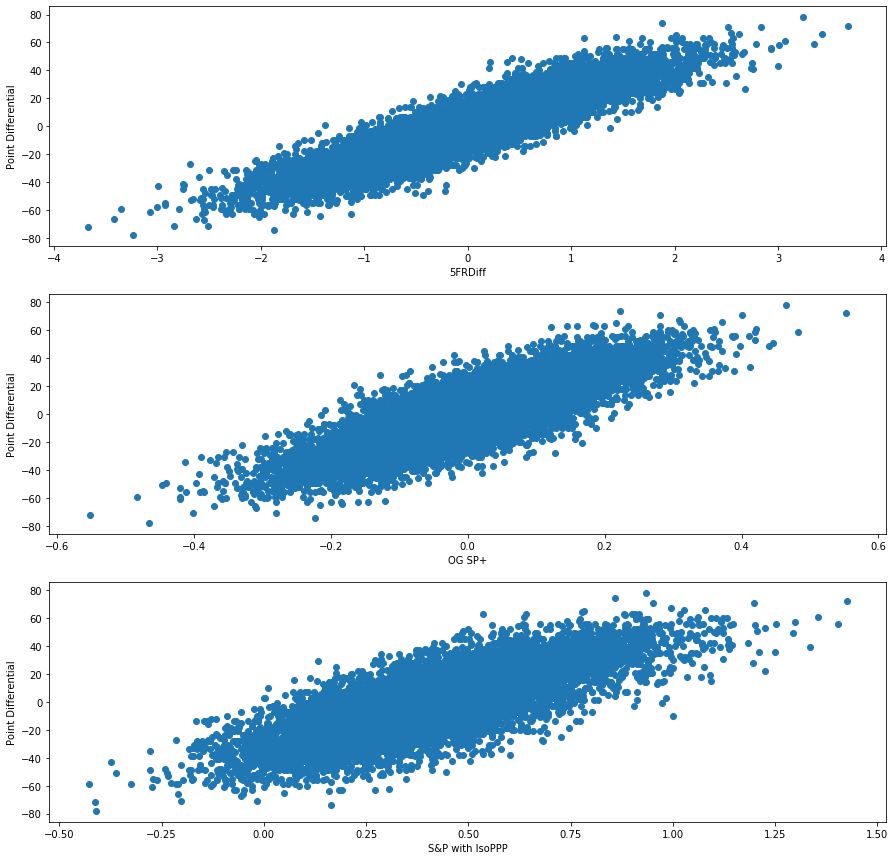

In [16]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [17]:
fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
fg.update_layout(
    title="5FR Margin vs Point Margin (2012-2019)",
    xaxis_title="5FR Margin",
    yaxis_title="Point Margin")
fg.show()

In [18]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

OGS&PDiff  S&PIsoPPPDiff   PtsDiff
OGS&PDiff       1.000000       0.911990  0.759463
S&PIsoPPPDiff   0.911990       1.000000  0.816783
PtsDiff         0.759463       0.816783  1.000000

In [19]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  \
0               UCF    2012  322432006  56.0     42.0        0.796214   
1             Akron    2012  322432006  14.0    -42.0        0.203786   
2    South Carolina    2012  322430238  17.0      4.0        0.518995   
3        Vanderbilt    2012  322430238  13.0     -4.0        0.481005   
4  Eastern Michigan    2012  322432050  26.0    -11.0        0.020080   

      OffSR     OffER       YPP    IsoPPP  ...  SackRateDiff  KickoffSRDiff  \
0  0.492537  0.074627  6.029851  0.683285  ...      0.007186       0.388889   
1  0.382716  0.061728  4.370370  0.641765  ...     -0.007186      -0.388889   
2  0.435484  0.080645  5.129032  0.749257  ...      0.036359      -0.333333   
3  0.271186  0.152542  5.813559  1.171577  ...     -0.036359       0.333333   
4  0.447761  0.134328  6.119403  1.072704  ...      0.010417      -0.416667   

   KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  FGEffDiff       5FR  \
0             0.000000    0.200000          0.200000   0.000000  5.453906   
1             0.000000   -0.200000         -0.200000   0.000000  4.546094   
2            -0.333333   -0.250000         -0.250000   0.333333  5.207552   
3             0.333333    0.250000          0.250000  -0.333333  4.792448   
4            -0.541667   -0.095238         -0.095238  -0.750000  4.744612   

    5FRDiff  5fr_z_score  pts_z_score  
0  0.907813     1.037223     1.907384  
1 -0.907813     1.037223     1.907384  
2  0.415104     0.474277     0.181656  
3 -0.415104     0.474277     0.181656  
4 -0.510776     0.583588     0.499553  

[5 rows x 55 columns]

In [20]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [21]:
# outliers

In [22]:
train_data.head()

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  \
0               UCF    2012  322432006  56.0     42.0        0.796214   
2    South Carolina    2012  322430238  17.0      4.0        0.518995   
3        Vanderbilt    2012  322430238  13.0     -4.0        0.481005   
4  Eastern Michigan    2012  322432050  26.0    -11.0        0.020080   
6              UCLA    2012  322430242  49.0     25.0        0.361313   

      OffSR     OffER       YPP    IsoPPP  ...  SackRateDiff  KickoffSRDiff  \
0  0.492537  0.074627  6.029851  0.683285  ...      0.007186       0.388889   
2  0.435484  0.080645  5.129032  0.749257  ...      0.036359      -0.333333   
3  0.271186  0.152542  5.813559  1.171577  ...     -0.036359       0.333333   
4  0.447761  0.134328  6.119403  1.072704  ...      0.010417      -0.416667   
6  0.536232  0.130435  9.173913  0.824934  ...      0.060758       0.200000   

   KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  FGEffDiff       5FR  \
0             0.000000    0.200000          0.200000   0.000000  5.453906   
2            -0.333333   -0.250000         -0.250000   0.333333  5.207552   
3             0.333333    0.250000          0.250000  -0.333333  4.792448   
4            -0.541667   -0.095238         -0.095238  -0.750000  4.744612   
6             0.200000    0.291667          0.291667   0.500000  5.381749   

    5FRDiff  5fr_z_score  pts_z_score  
0  0.907813     1.037223     1.907384  
2  0.415104     0.474277     0.181656  
3 -0.415104     0.474277     0.181656  
4 -0.510776     0.583588     0.499553  
6  0.763498     0.872336     1.135348  

[5 rows x 55 columns]

In [23]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [24]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Linear Regression: y = 22.65330x + 0.03479
Mean Pred Score: 0.3970915385351306
Pred Std Dev: 19.65409421198681
Mean Abs Error: 7.708724372082197
Mdn Abs Error: 6.264734807472442
R-squared: 0.8010510254466079
Adj R-squared: 0.800963805378851



ActPtsDiff  OffSRDiff  OffERDiff    FPDiff  OppRateDiff  \
ActPtsDiff             1.000000   0.764033   0.607497  0.481658     0.792958   
OffSRDiff              0.764033   1.000000   0.512649  0.294542     0.695316   
OffERDiff              0.607497   0.512649   1.000000  0.169946     0.530378   
FPDiff                 0.481658   0.294542   0.169946  1.000000     0.617153   
OppRateDiff            0.792958   0.695316   0.530378  0.617153     1.000000   
OppEffDiff             0.590422   0.377493   0.326440  0.075612     0.191061   
OppPPDDiff             0.598705   0.432403   0.355942  0.054854     0.199747   
PPDDiff                0.983418   0.763444   0.598674  0.454385     0.792898   
OppSRDiff              0.516033   0.747512   0.360029  0.034642     0.259983   
YPPDiff                0.796049   0.736246   0.822039  0.259508     0.682463   
ExpTODiff             -0.454148  -0.290909  -0.214135 -0.303522    -0.320671   
ActualTODiff          -0.464708  -0.204308  -0.165653 -0.372106    -0.320682   
AvgEqPPPDiff           0.744564   0.667796   0.774116  0.258954     0.613284   
TotalEqPPPDiff         0.762160   0.763702   0.639707  0.244212     0.746970   
IsoPPPDiff             0.288686  -0.006570   0.586706  0.067855     0.181446   
HavocRateDiff          0.532153   0.528606   0.222447  0.271700     0.505359   
SackRateDiff           0.459033   0.409668   0.221951  0.261001     0.410722   
KickoffSRDiff          0.233572   0.186049   0.142302  0.319611     0.245505   
KickoffReturnSRDiff    0.136520   0.086508   0.075159  0.221024     0.157523   
PuntSRDiff             0.035190  -0.023025   0.019387  0.164102     0.004123   
PuntReturnSRDiff       0.104067   0.045046   0.065034  0.188906     0.081277   
FGEffDiff              0.193908   0.098237   0.065244  0.179044     0.230118   
5FR                    0.895057   0.919854   0.557807  0.566118     0.827922   
5FRDiff                0.895057   0.919854   0.557807  0.566118     0.827922   
PredPtsDiff            0.895057   0.919854   0.557807  0.566118     0.827922   

                     OppEffDiff  OppPPDDiff   PPDDiff  OppSRDiff   YPPDiff  \
ActPtsDiff             0.590422    0.598705  0.983418   0.516033  0.796049   
OffSRDiff              0.377493    0.432403  0.763444   0.747512  0.736246   
OffERDiff              0.326440    0.355942  0.598674   0.360029  0.822039   
FPDiff                 0.075612    0.054854  0.454385   0.034642  0.259508   
OppRateDiff            0.191061    0.199747  0.792898   0.259983  0.682463   
OppEffDiff             1.000000    0.746643  0.589158   0.473169  0.431607   
OppPPDDiff             0.746643    1.000000  0.609538   0.535955  0.479395   
PPDDiff                0.589158    0.609538  1.000000   0.513619  0.785616   
OppSRDiff              0.473169    0.535955  0.513619   1.000000  0.546307   
YPPDiff                0.431607    0.479395  0.785616   0.546307  1.000000   
ExpTODiff             -0.273692   -0.286837 -0.444542  -0.230495 -0.336686   
ActualTODiff          -0.284209   -0.275650 -0.454313  -0.132666 -0.238851   
AvgEqPPPDiff           0.404301    0.454154  0.730273   0.504482  0.925583   
TotalEqPPPDiff         0.352493    0.371100  0.738207   0.454723  0.804678   
IsoPPPDiff             0.205898    0.223964  0.272432   0.020323  0.548204   
HavocRateDiff          0.276826    0.292587  0.536279   0.337119  0.457237   
SackRateDiff           0.254899    0.288238  0.455388   0.266067  0.405806   
KickoffSRDiff          0.109003    0.093052  0.228226   0.128071  0.171988   
KickoffReturnSRDiff    0.049037    0.062146  0.132229   0.025940  0.090151   
PuntSRDiff             0.038534    0.017442  0.033824  -0.031725 -0.011857   
PuntReturnSRDiff       0.066322    0.046779  0.110034  -0.004539  0.048891   
FGEffDiff              0.365715    0.073747  0.182840  -0.047530  0.090713   
5FR                    0.461430    0.535290  0.888714   0.653259  0.779396   
5FRDiff                0.461430    0.535290  0.888714   0.653259  0.

In [25]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

ActPtsDiff    ActPts       Eff      Expl    FinDrv    FldPos  \
ActPtsDiff     1.000000  0.754088  0.764033  0.744564  0.905335  0.481658   
ActPts         0.754088  1.000000  0.578962  0.555929  0.680037  0.353675   
Eff            0.764033  0.578962  1.000000  0.667796  0.802961  0.294542   
Expl           0.744564  0.555929  0.667796  1.000000  0.716231  0.258954   
FinDrv         0.905335  0.680037  0.802961  0.716231  1.000000  0.415052   
FldPos         0.481658  0.353675  0.294542  0.258954  0.415052  1.000000   
Trnovr         0.507570  0.386243  0.300084  0.277165  0.433197  0.371167   
5FR            0.895057  0.673527  0.919854  0.725519  0.920295  0.566118   
5FRDiff        0.895057  0.673527  0.919854  0.725519  0.920295  0.566118   
PredPtsDiff    0.895057  0.673527  0.919854  0.725519  0.920295  0.566118   

               Trnovr       5FR   5FRDiff  PredPtsDiff  
ActPtsDiff   0.507570  0.895057  0.895057     0.895057  
ActPts       0.386243  0.673527  0.673527     0.673527  
Eff          0.300084  0.919854  0.919854     0.919854  
Expl         0.277165  0.725519  0.725519     0.725519  
FinDrv       0.433197  0.920295  0.920295     0.920295  
FldPos       0.371167  0.566118  0.566118     0.566118  
Trnovr       1.000000  0.502500  0.502500     0.502500  
5FR          0.502500  1.000000  1.000000     1.000000  
5FRDiff      0.502500  1.000000  1.000000     1.000000  
PredPtsDiff  0.502500  1.000000  1.000000     1.000000

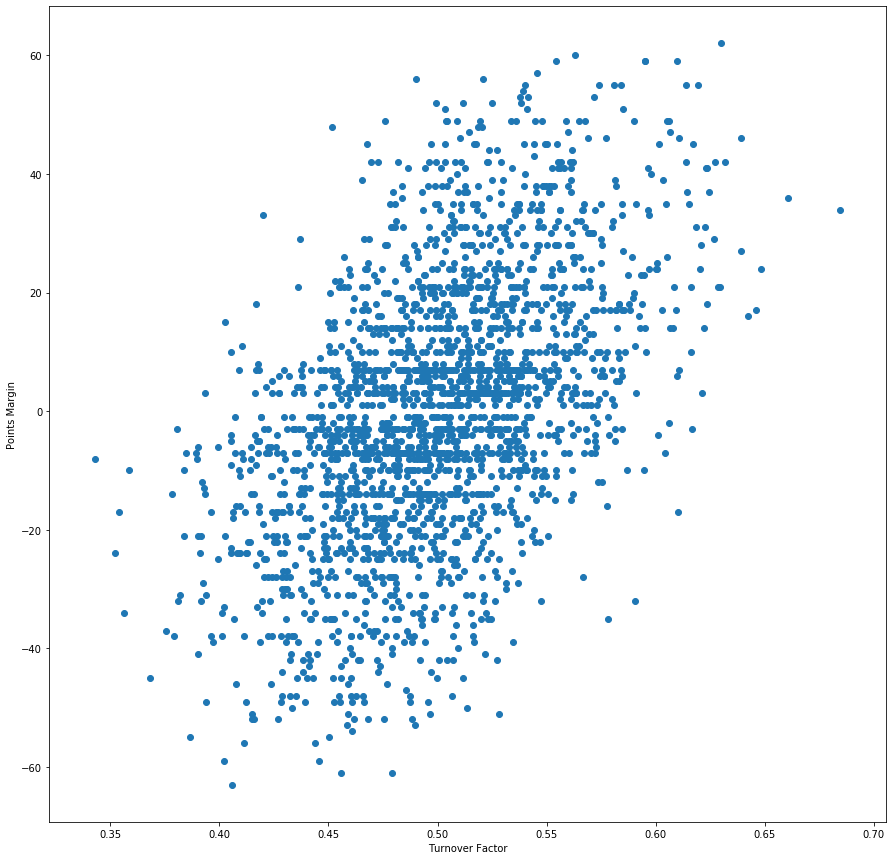

In [26]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

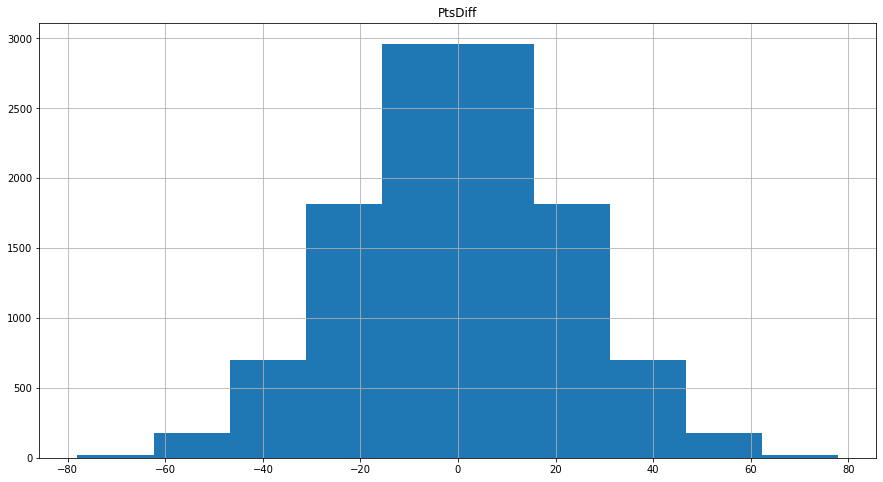

In [27]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

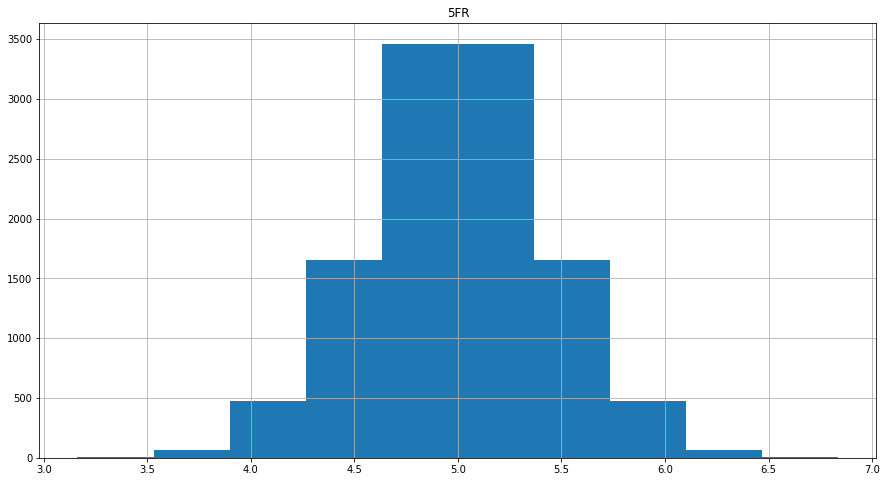

In [28]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

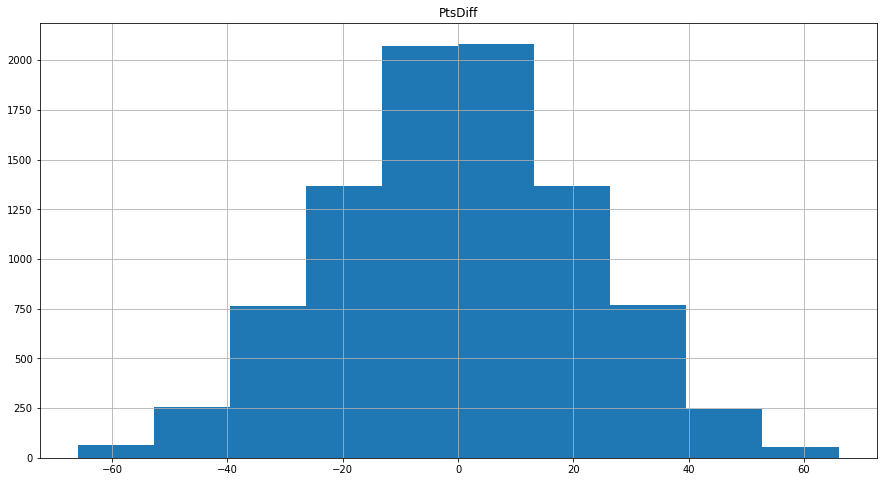

In [29]:
train_data.hist(column='PtsDiff', figsize=(15,8));

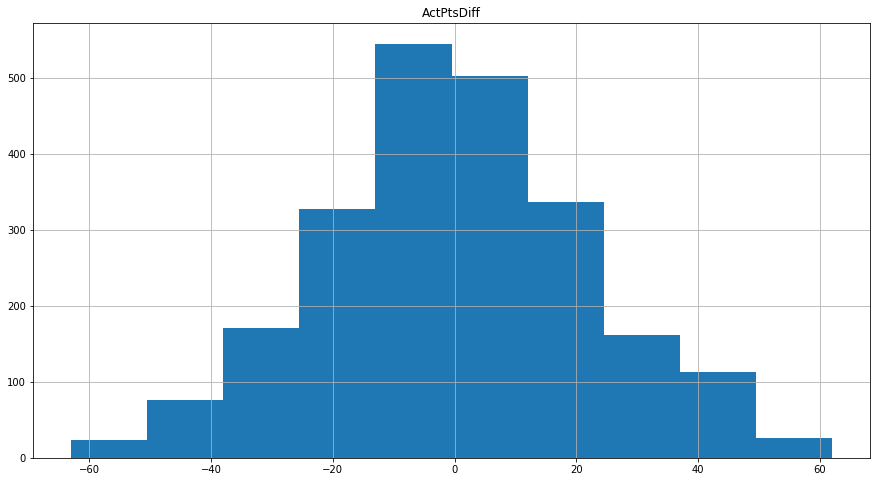

In [30]:
test.hist(column='ActPtsDiff', figsize=(15,8));

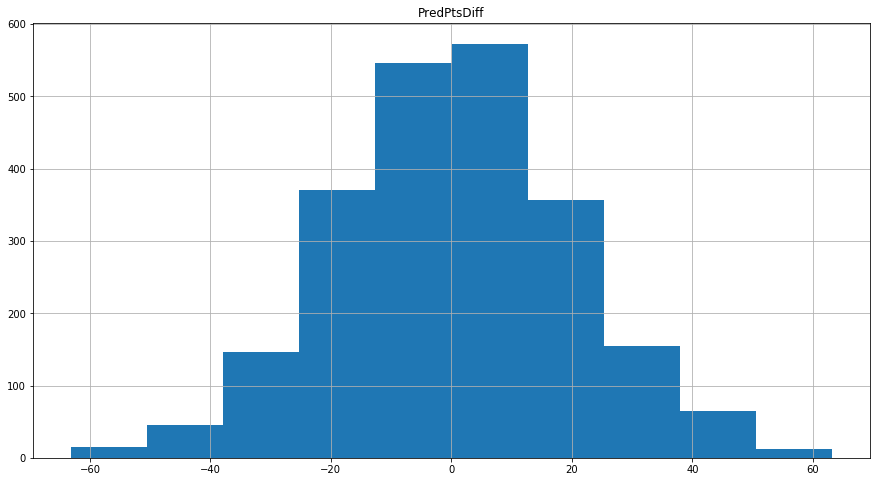

In [31]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [32]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [33]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3.0 (exact value: -3.162424126716078)
Z score: -0.18110810026952556
Win Prob for Virginia Tech: 42.81%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0       Virginia    2018  401013183  31.0     -3.0        0.875665  0.396825   
1  Virginia Tech    2018  401013183  34.0      3.0        0.124335  0.368421   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.111111  6.507937  0.930578  ...    0.124959      -0.040309     -0.002715   
1  0.078947  5.513158  0.805619  ...   -0.124959       0.040309      0.002715   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0            0.0             0.166667    0.119048          0.119048   
1            0.0            -0.166667   -0.119048         -0.119048   

   FGEffDiff       5FR   5FRDiff  
0   0.333333  5.070568  0.141137  
1  -0.333333  4.929432 -0.141137  

[2 rows x 53 columns]

In [34]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -11.0 (exact value: -11.26909951658921)
Z score: -0.5935756147952758
Win Prob for Georgia Tech: 27.64%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0  Georgia Tech    2019  401112488  28.0      7.0        0.065752  0.396825   
1         Miami    2019  401112488  21.0     -7.0        0.934248  0.370968   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.111111  5.460317  0.894136  ...   -0.121075       0.018689      0.000768   
1  0.112903  5.790323  1.015211  ...    0.121075      -0.018689     -0.000768   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0            0.0                  0.0    0.166667          0.166667   
1            0.0                  0.0   -0.166667         -0.166667   

   FGEffDiff       5FR   5FRDiff  
0        0.0  4.750502 -0.498995  
1        0.0  5.249498  0.498995  

[2 rows x 53 columns]

In [35]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.5367722362184515)
Z score: -0.04751497396323811
Win Prob for Georgia Tech: 48.11%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0      NC State    2019  401112513  26.0     -2.0        0.156447  0.487500   
1  Georgia Tech    2019  401112513  28.0      2.0        0.843553  0.473684   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.150000  5.712500  0.704891  ...   -0.300725       0.012719           0.0   
1  0.140351  7.035088  1.005617  ...    0.300725      -0.012719           0.0   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0      -0.133333             0.066667         0.0               0.0   
1       0.133333            -0.066667         0.0               0.0   

   FGEffDiff       5FR   5FRDiff  
0        1.0  5.012615  0.025231  
1       -1.0  4.987385 -0.025231  

[2 rows x 53 columns]

In [36]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 4.0 (exact value: 3.557063548885314)
Z score: 0.160779325481352
Win Prob for Mississippi State: 56.39%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  \
0           Ole Miss    2019  401110863  20.0     -1.0        0.384124   
1  Mississippi State    2019  401110863  21.0      1.0        0.615876   

      OffSR     OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  \
0  0.422535  0.070423  5.563380  0.880173  ...    0.092249       0.000243   
1  0.413793  0.137931  5.482759  0.787924  ...   -0.092249      -0.000243   

   SackRateDiff  KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  \
0     -0.004614      -0.666667            -0.333333         0.0   
1      0.004614       0.666667             0.333333         0.0   

   PuntReturnSRDiff  FGEffDiff       5FR   5FRDiff  
0               0.0          0  4.922257 -0.155486  
1               0.0          0  5.077743  0.155486  

[2 rows x 53 columns]

In [37]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -5.0 (exact value: -4.9472981002636445)
Z score: -0.2719224595727893
Win Prob for Texas A&M: 39.28%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0        LSU    2018  401012356  72.0     -2.0        0.321374  0.466667   
1  Texas A&M    2018  401012356  74.0      2.0        0.678626  0.423077   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.088889  5.511111  0.682602  ...   -0.349878       0.001282     -0.047436   
1  0.105769  4.634615  1.032480  ...    0.349878      -0.001282      0.047436   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0            0.2                  0.2       -0.25             -0.25   
1           -0.2                 -0.2        0.25              0.25   

   FGEffDiff       5FR   5FRDiff  
0      -0.25  5.109964  0.219927  
1       0.25  4.890036 -0.219927  

[2 rows x 53 columns]

In [38]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

team  avg_win_prob  games  proj_wins  proj_losses
1           Ohio State      0.940096     13       12.0          1.0
2              Clemson      0.933295     13       12.0          1.0
3              Alabama      0.908957     12       11.0          1.0
4                  LSU      0.907375     13       12.0          1.0
5            Wisconsin      0.870465     13       11.0          2.0
6                 Utah      0.840528     13       11.0          2.0
7             Oklahoma      0.822988     13       11.0          2.0
8               Oregon      0.809388     13       11.0          2.0
9    Appalachian State      0.794061     13       10.0          3.0
10             Georgia      0.785969     13       10.0          3.0
11          Notre Dame      0.777665     12        9.0          3.0
12          Penn State      0.759457     12        9.0          3.0
13           Minnesota      0.754854     12        9.0          3.0
14             Memphis      0.751797     13       10.0          3.0
15            Michigan      0.733736     12        9.0          3.0
16           Louisiana      0.733226     13       10.0          3.0
17                 UCF      0.716950     12        9.0          3.0
18    Florida Atlantic      0.706385     13        9.0          4.0
19           Air Force      0.704863     13        9.0          4.0
20                Navy      0.702812     12        8.0          4.0
21                Ohio      0.697076     12        8.0          4.0
22             Florida      0.696788     12        8.0          4.0
23          Iowa State      0.691402     12        8.0          4.0
24              Auburn      0.690563     12        8.0          4.0
25              Baylor      0.685714     13        9.0          4.0
26    Western Kentucky      0.672675     12        8.0          4.0
27          Washington      0.661065     12        8.0          4.0
28         Boise State      0.659325     13        9.0          4.0
29                 SMU      0.656246     12        8.0          4.0
30     San Diego State      0.651991     12        8.0          4.0
..                 ...           ...    ...        ...          ...
101               UCLA      0.334513     12        4.0          8.0
102         Miami (OH)      0.332274     13        4.0          9.0
103           Stanford      0.327354     12        4.0          8.0
104             Nevada      0.326105     12        4.0          8.0
105             Toledo      0.316443     12        4.0          8.0
106           NC State      0.311755     12        4.0          8.0
107  Northern Illinois      0.285881     12        3.0          9.0
108         New Mexico      0.262333     13        3.0         10.0
109      West Virginia      0.253111     12        3.0          9.0
110      South Florida      0.247744     12        3.0          9.0
111               UNLV      0.244296     12        3.0          9.0
112       Old Dominion      0.230728     12        3.0          9.0
113            Arizona      0.222706     12        3.0          9.0
114      East Carolina      0.220679     12        3.0          9.0
115             Kansas      0.220598     12        3.0          9.0
116     UT San Antonio      0.214367     12        3.0          9.0
117               UTEP      0.209234     12        3.0          9.0
118       Georgia Tech      0.185963     12        2.0         10.0
119           Arkansas      0.182758     12        2.0         10.0
120   New Mexico State      0.179826     12        2.0         10.0
121           Maryland      0.175681     12        2.0         10.0
122      South Alabama      0.159085     12        2.0         10.0
123        Texas State      0.147282     12        2.0         10.0
124         Vanderbilt      0.138540     12        2.0         10.0
125      Bowling Green      0.133168     12        2.0         10.0
126        Connecticut      0.123769     12        1.0         11.0
127            Rutgers      0.099345     12        1.0         11.0
128   

In [39]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

team  second_order_wins  second_order_losses
77          Ohio State          11.486176             1.513824
21             Clemson          10.581286             2.418714
53                 LSU          10.355508             2.644492
128          Wisconsin           9.598662             3.401338
2              Alabama           9.286654             2.713346
115               Utah           9.137718             3.862282
78            Oklahoma           9.033895             3.966105
3    Appalachian State           8.710244             4.289756
82              Oregon           8.707445             4.292555
34             Georgia           8.497264             4.502736
56             Memphis           8.436599             4.563401
75          Notre Dame           8.361454             3.638546
49           Louisiana           8.245572             4.754428
30    Florida Atlantic           8.129940             4.870060
59            Michigan           8.053963             3.946037
20          Cincinnati           7.914588             5.085412
11              Baylor           7.796494             5.203506
91                 SMU           7.763625             4.236375
62           Minnesota           7.752415             4.247585
12         Boise State           7.706217             5.293783
0            Air Force           7.420003             5.579997
84          Penn State           7.415857             4.584143
110                UCF           7.398338             4.601662
42                Iowa           7.344066             4.655934
120           Virginia           7.331489             5.668511
125   Western Kentucky           7.183156             4.816844
18    Central Michigan           7.151109             5.848891
43          Iowa State           7.145570             4.854430
76                Ohio           7.003116             4.996884
114                USC           6.999910             5.000090
..                 ...                ...                  ...
96            Stanford           4.299527             7.700473
17          California           4.286347             7.713653
61    Middle Tennessee           4.080648             7.919352
39             Houston           4.060161             7.939839
66            NC State           3.925735             8.074265
105             Toledo           3.839004             8.160996
95       South Florida           3.817210             8.182790
72   Northern Illinois           3.669294             8.330706
127      West Virginia           3.554047             8.445953
55            Maryland           3.370296             8.629704
44              Kansas           3.279190             8.720810
69          New Mexico           3.186051             9.813949
113               UNLV           3.052863             8.947137
118     UT San Antonio           2.962277             9.037723
6             Arkansas           2.919772             9.080228
4              Arizona           2.911296             9.088704
117               UTEP           2.824663             9.175337
80        Old Dominion           2.818634             9.181366
37        Georgia Tech           2.752998             9.247002
27       East Carolina           2.643486             9.356514
70    New Mexico State           2.599278             9.400722
88             Rutgers           2.447970             9.552030
92       South Alabama           2.415812             9.584188
14       Bowling Green           2.384736             9.615264
119         Vanderbilt           2.266888             9.733112
25         Connecticut           1.984294            10.015706
103        Texas State           1.910203            10.089797
1                Akron           1.668556            10.331444
112              UMass           1.547777            10.452223
90      San José State           0.000000            12.000000

[130 rows x 3 columns]

In [40]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

Team  Season       5FR  Rank
0                   Alabama    2012  5.557889     1
1             Florida State    2012  5.454605     2
2                       BYU    2012  5.335653     3
3             Arizona State    2012  5.333539     4
4                  Oklahoma    2012  5.331083     5
5              Fresno State    2012  5.309021     6
6                   Georgia    2012  5.304040     7
7                Notre Dame    2012  5.289858     8
8                Utah State    2012  5.267835     9
9              Kansas State    2012  5.266560    10
10               Ohio State    2012  5.254690    11
11              Boise State    2012  5.253825    12
12        Northern Illinois    2012  5.242658    13
13                 Stanford    2012  5.231914    14
14           Michigan State    2012  5.230525    15
15           Louisiana Tech    2012  5.225686    16
16                Wisconsin    2012  5.225455    17
17                   Oregon    2012  5.213559    18
18           North Carolina    2012  5.210022    19
19                  Florida    2012  5.208728    20
20                  Clemson    2012  5.194078    21
21                     UCLA    2012  5.193418    22
22                    Texas    2012  5.193407    23
23                      LSU    2012  5.192014    24
24               Ball State    2012  5.189877    25
25            Bowling Green    2012  5.178791    26
26               Penn State    2012  5.177198    27
27                Texas A&M    2012  5.167496    28
28                    Tulsa    2012  5.154307    29
29    San JosÃÂÃÂ© State    2012  5.153023    30
...                     ...     ...       ...   ...
1000             California    2019  4.824965   101
1001                   UCLA    2019  4.822553   102
1002             Miami (OH)    2019  4.819881   103
1003               Stanford    2019  4.813987   104
1004                 Nevada    2019  4.812484   105
1005                 Toledo    2019  4.800783   106
1006               NC State    2019  4.795051   107
1007      Northern Illinois    2019  4.762700   108
1008             New Mexico    2019  4.732025   109
1009          West Virginia    2019  4.719635   110
1010          South Florida    2019  4.712315   111
1011                   UNLV    2019  4.707567   112
1012           Old Dominion    2019  4.688523   113
1013                Arizona    2019  4.676968   114
1014          East Carolina    2019  4.674011   115
1015                 Kansas    2019  4.673893   116
1016         UT San Antonio    2019  4.664703   117
1017                   UTEP    2019  4.657016   118
1018           Georgia Tech    2019  4.620667   119
1019               Arkansas    2019  4.615447   120
1020       New Mexico State    2019  4.610621   121
1021               Maryland    2019  4.603714   122
1022          South Alabama    2019  4.574965   123
1023            Texas State    2019  4.553301   124
1024             Vanderbilt    2019  4.536497   125
1025          Bowling Green    2019  4.525809   126
1026            Connecticut    2019  4.506369   127
1027                Rutgers    2019  4.450434   128
1028                  Akron    2019  4.402725   129
1029                  UMass    2019  4.380957   130

[1030 rows x 4 columns]

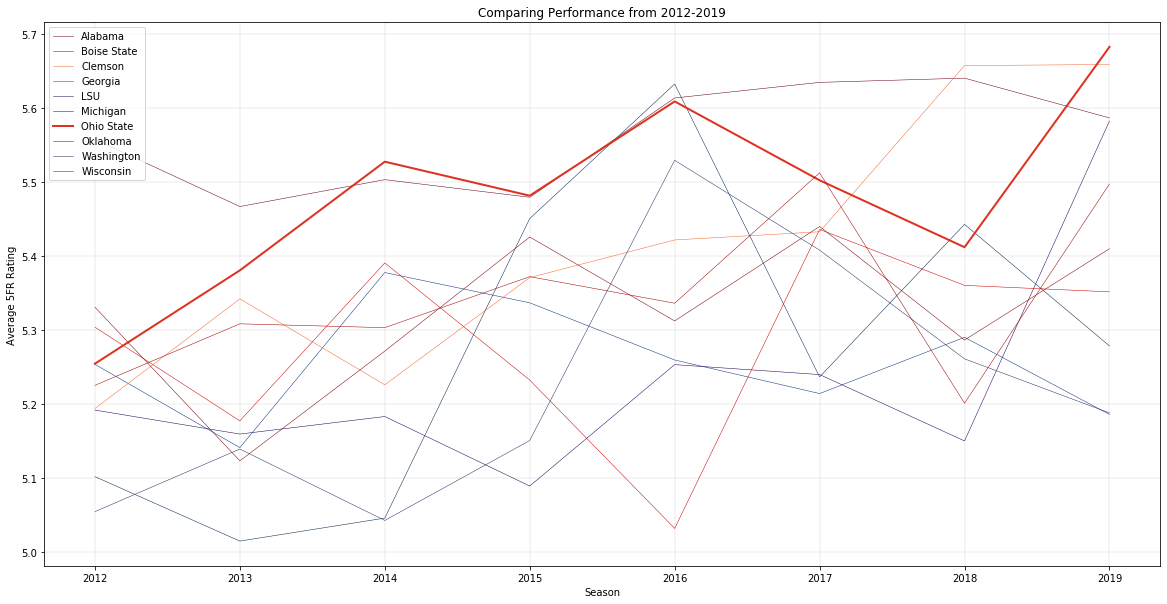

In [41]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [42]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

Team    Avg5FR
0                  Alabama  5.560512
1               Ohio State  5.481456
2                  Clemson  5.413149
3                Wisconsin  5.344711
4                 Oklahoma  5.325188
5                  Georgia  5.285696
6                 Michigan  5.275654
7              Boise State  5.257562
8                      LSU  5.231349
9               Washington  5.221882
10              Penn State  5.215490
11                     TCU  5.205342
12              Notre Dame  5.188622
13                  Oregon  5.188359
14          Michigan State  5.178336
15           Florida State  5.173927
16                 Memphis  5.149976
17         San Diego State  5.144785
18           Virginia Tech  5.144595
19                 Florida  5.143926
20        Western Kentucky  5.143094
21                     UCF  5.139251
22                  Baylor  5.136652
23                Stanford  5.135985
24                     USC  5.132576
25       Mississippi State  5.131748
26                  Auburn  5.120132
27          Oklahoma State  5.110050
28       Appalachian State  5.109015
29          Louisiana Tech  5.104254
..                     ...       ...
100            Wake Forest  4.840130
101  Florida International  4.839042
102                 Tulane  4.837001
103                    SMU  4.832373
104             New Mexico  4.831570
105               Colorado  4.820741
106  San JosÃÂÃÂ© State  4.814690
107           Oregon State  4.814207
108       Louisiana Monroe  4.805533
109                Hawai'i  4.803057
110       Eastern Michigan  4.798587
111             Miami (OH)  4.787811
112               Illinois  4.783708
113          South Alabama  4.781208
114               Maryland  4.771085
115                Liberty  4.770654
116                   UNLV  4.760427
117            Texas State  4.754636
118           Old Dominion  4.753152
119             Kent State  4.750290
120                  Akron  4.748208
121            Connecticut  4.730000
122                   UTEP  4.720235
123                Rutgers  4.719740
124              Charlotte  4.711808
125          Georgia State  4.706279
126                  UMass  4.678491
127       New Mexico State  4.678160
128       Coastal Carolina  4.621592
129                 Kansas  4.588694

[130 rows x 2 columns]

In [43]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

Team  Season       5FR  Rank
900     Ohio State    2019  5.682812     1
127  Florida State    2013  5.667090     1
901        Clemson    2019  5.659044     2
770        Clemson    2018  5.657551     1
771        Alabama    2018  5.640608     2
640        Alabama    2017  5.634880     1
512       Michigan    2016  5.632687     1
513        Alabama    2016  5.613788     2
514     Ohio State    2016  5.609128     3
902        Alabama    2019  5.586845     3

In [44]:
strength_max[strength_max.Team == "Georgia Tech"]

Team  Season       5FR  Rank
280   Georgia Tech    2014  5.189151    25
65    Georgia Tech    2012  5.002690    66
194   Georgia Tech    2013  4.998730    68
844   Georgia Tech    2018  4.984770    75
727   Georgia Tech    2017  4.918923    88
592   Georgia Tech    2016  4.894851    81
473   Georgia Tech    2015  4.827962    90
1018  Georgia Tech    2019  4.620667   119

In [45]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

GameID               Opponent  Season       Team  Week
0      322520130.0               Michigan  2012.0  Air Force   1.0
1      322662439.0                   UNLV  2012.0  Air Force   2.0
2      322732005.0         Colorado State  2012.0  Air Force   3.0
3      322802005.0                   Navy  2012.0  Air Force   4.0
4      322872751.0                Wyoming  2012.0  Air Force   5.0
5      322942005.0             New Mexico  2012.0  Air Force   6.0
6      323002005.0                 Nevada  2012.0  Air Force   7.0
7      323080349.0                   Army  2012.0  Air Force   8.0
8      323150021.0        San Diego State  2012.0  Air Force   9.0
9      323212005.0                Hawai'i  2012.0  Air Force  10.0
10     323290278.0           Fresno State  2012.0  Air Force  11.0
11     332502005.0             Utah State  2013.0  Air Force   1.0
12     332560068.0            Boise State  2013.0  Air Force   2.0
13     332642005.0                Wyoming  2013.0  Air Force   3.0
14     332712440.0                 Nevada  2013.0  Air Force   4.0
15     332782426.0                   Navy  2013.0  Air Force   5.0
16     332832005.0        San Diego State  2013.0  Air Force   6.0
17     332992005.0             Notre Dame  2013.0  Air Force   7.0
18     333062005.0                   Army  2013.0  Air Force   8.0
19     333120167.0             New Mexico  2013.0  Air Force   9.0
20     333252005.0                   UNLV  2013.0  Air Force  10.0
21     333340036.0         Colorado State  2013.0  Air Force  11.0
22     400548180.0                Wyoming  2014.0  Air Force   1.0
23     400548189.0          Georgia State  2014.0  Air Force   2.0
24     400548199.0            Boise State  2014.0  Air Force   3.0
25     400548205.0                   Navy  2014.0  Air Force   4.0
26     400548210.0             Utah State  2014.0  Air Force   5.0
27     400548215.0             New Mexico  2014.0  Air Force   6.0
28     400548226.0                   Army  2014.0  Air Force   7.0
29     400548232.0                   UNLV  2014.0  Air Force   8.0
...            ...                    ...     ...        ...   ...
11223  400944845.0            Texas State  2017.0    Wyoming   4.0
11224  400945276.0             Utah State  2017.0    Wyoming   5.0
11225  400945279.0            Boise State  2017.0    Wyoming   6.0
11226  400945285.0             New Mexico  2017.0    Wyoming   7.0
11227  400945290.0         Colorado State  2017.0    Wyoming   8.0
11228  400945295.0              Air Force  2017.0    Wyoming   9.0
11229  400945304.0           Fresno State  2017.0    Wyoming  10.0
11230  400945309.0  San JosÃÂÃÂ© State  2017.0    Wyoming  11.0
11231  401013437.0       New Mexico State  2018.0    Wyoming   1.0
11232  401012683.0       Washington State  2018.0    Wyoming   2.0
11233  401012267.0               Missouri  2018.0    Wyoming   3.0
11234  401022526.0            Boise State  2018.0    Wyoming   4.0
11235  401022531.0                Hawai'i  2018.0    Wyoming   5.0
11236  401022537.0           Fresno State  2018.0    Wyoming   6.0
11237  401022540.0             Utah State  2018.0    Wyoming   7.0
11238  401022546.0         Colorado State  2018.0    Wyoming   8.0
11239  401022552.0  San JosÃÂÃÂ© State  2018.0    Wyoming   9.0
11240  401022559.0              Air Force  2018.0    Wyoming  10.0
11241  401022567.0             New Mexico  2018.0    Wyoming  11.0
11242  401110728.0               Missouri  2019.0    Wyoming   1.0
11243  401117500.0            Texas State  2019.0    Wyoming   2.0
11244  401117509.0                  Tulsa  2019.0    Wyoming   3.0
11245  401117514.0                   UNLV  2019.0    Wyoming   4.0
11246  401117523.0        San Diego State  2019.0    Wyoming   5.0
11247  401117526.0             New Mexico  2019.0    Wyoming   6.0
11248  401117533.0                 Nevada  2019.0    Wyoming   7.0
11249  401117541.0            Boise State  2019.0    Wyoming   8.0
11250  401117546.0             Utah State  2019.0    Wyomin

In [46]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += 2.5
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.14323625775981058, -20.55204808700384]

In [47]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
#     ['North Carolina','Temple',5], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5], # MichSt 27, Wake 21
#     ['Texas A&M', 'Oklahoma State', 7], # TAMU 24, OKST 21
#     ['Iowa', 'USC', 2.5], # Iowa 48, USC 24
#     ['Air Force', 'Washington State', 3], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
#     ['Penn State','Memphis',7], # Cotton Bowl - PennSt 53, Memphis 39
#     ['Notre Dame', 'Iowa State', 4], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
#     ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
#     ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
#     ['Western Kentucky', 'Western Michigan', 3.5], # WKU 23, WMU 20
#     ['Mississippi State', 'Louisville', 4], # LOU 38, MSST 28
#     ['California', 'Illinois', 6.5], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
#     ['Florida','Virginia',14], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
#     ['Virginia Tech', 'Kentucky', 3], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
#     ['Arizona State', 'Florida State', 4],
#    ----- 19-8 SU / 14-13 ATS ------  
#     ['Navy', 'Kansas State', 2],
#    ----- 20-8 SU / 15-13 ATS ------  
#     ['Wyoming', 'Georgia State', 7],
#    ----- 21-8 SU / 15-14 ATS ------  
#     ['Utah', 'Texas', 7],
#    ----- 21-9 SU / 16-14 ATS ------     
#     ['Auburn', 'Minnesota', 7.5], # Minnesota 31, Auburn 24
#     ['Alabama', 'Michigan', 7], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
#     ['Wisconsin','Oregon',2.5], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
#     ['Georgia','Baylor',7.5], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
#     ['Cincinnati', 'Boston College',7], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
#     ['Tennessee', 'Indiana', 1.5], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
#     ['Ohio', 'Nevada', 7.5], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
#     ['Tulane', 'Southern Mississippi', 7], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
#     ['Louisiana', 'Miami (OH)', 14] # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

favorite opponent  spread  proj_MOV  proj_win_prob  proj_cover_status  \
0      LSU  Clemson       6 -1.976513       0.451937              False   

   ml_pick ats_pick  
0  Clemson  Clemson

In [48]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 0.0 (exact value: 0.3112190881268402)
Z score: -0.004369188907007363
Win Prob for Virginia: 49.83%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0  Virginia Tech    2019  401112521  30.0     -9.0        0.577256  0.432432   
1       Virginia    2019  401112521  39.0      9.0        0.422744  0.381818   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.162162  6.540541  1.169095  ...   -0.403644      -0.089435     -0.044717   
1  0.181818  8.872727  1.572739  ...    0.403644       0.089435      0.044717   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0           0.25                0.125    0.333333          0.333333   
1          -0.25               -0.125   -0.333333         -0.333333   

   FGEffDiff       5FR   5FRDiff  
0        0.0  4.993899 -0.012203  
1        0.0  5.006101  0.012203  

[2 rows x 53 columns]

In [49]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.533334177712975)
Z score: 0.5157318637963924
Win Prob for North Carolina: 69.70%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0  North Carolina    2019  401112475  38.0     16.0         0.98905  0.457447   
1    Georgia Tech    2019  401112475  22.0    -16.0         0.01095  0.396226   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.106383  5.744681  0.811309  ...   -0.235394       0.079888      0.037736   
1  0.150943  6.094340  1.046703  ...    0.235394      -0.079888     -0.037736   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0       0.238095             0.380952   -0.214286         -0.214286   
1      -0.238095            -0.380952    0.214286          0.214286   

   FGEffDiff       5FR   5FRDiff  
0        0.5  5.231722  0.463445  
1       -0.5  4.768278 -0.463445  

[2 rows x 53 columns]

In [50]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 19.0 (exact value: 19.03285268378286)
Z score: 0.9481872298079242
Win Prob for Pittsburgh: 82.85%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0    Pittsburgh    2019  401112498  20.0     10.0        0.970074  0.362319   
1  Georgia Tech    2019  401112498  10.0    -10.0        0.029926  0.204082   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.057971  5.086957  0.882151  ...   -0.248736       0.038746      0.026324   
1  0.061224  3.591837  1.130888  ...    0.248736      -0.038746     -0.026324   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0            0.0                  0.0         0.0               0.0   
1            0.0                  0.0         0.0               0.0   

   FGEffDiff       5FR   5FRDiff  
0   0.166667  5.419322  0.838645  
1  -0.166667  4.580678 -0.838645  

[2 rows x 53 columns]

In [51]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -9.63873862659993)
Z score: -0.5106228787187924
Win Prob for Auburn: 30.48%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0  Alabama    2019  401110865  45.0     -3.0        0.400109  0.453333   
1   Auburn    2019  401110865  48.0      3.0        0.599891  0.338710   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.133333  6.440000  0.905516  ...   -0.083465      -0.033763     -0.013333   
1  0.112903  5.322581  0.988981  ...    0.083465       0.033763      0.013333   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0       0.053571             0.160714   -0.666667         -0.666667   
1      -0.053571            -0.160714    0.666667          0.666667   

   FGEffDiff       5FR   5FRDiff  
0       -0.5  5.213512  0.427025  
1        0.5  4.786488 -0.427025  

[2 rows x 53 columns]

In [52]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 34.0 (exact value: 34.12223815115532)
Z score: 1.7159349216944126
Win Prob for Georgia: 95.69%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0       Georgia    2019  401110867  52.0     45.0        0.998507  0.472222   
1  Georgia Tech    2019  401110867   7.0    -45.0        0.001493  0.224138   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.138889  6.847222  0.969971  ...    0.455922       0.020115      0.003352   
1  0.034483  2.396552  0.514049  ...   -0.455922      -0.020115     -0.003352   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0       0.888889            -0.111111    0.461538          0.461538   
1      -0.888889             0.111111   -0.461538         -0.461538   

   FGEffDiff       5FR   5FRDiff  
0        0.5  5.752373  1.504745  
1       -0.5  4.247627 -1.504745  

[2 rows x 53 columns]

In [53]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 22.0 (exact value: 21.61286397594379)
Z score: 1.0794581631988618
Win Prob for Clemson: 85.98%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 10.0 (exact value: 9.519217399641)
Z score: 0.4641336183044441
Win Prob for Georgia Tech: 67.87%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -10.0 (exact value: -10.465237096631745)
Z score: -0.5526751076903897
Win Prob for The Citadel: 29.02%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 21.0 (exact value: 20.845743126482372)
Z score: 1.0404270666147435
Win Prob for Temple: 85.09%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.533334177712975)
Z score: 0.515731863796392

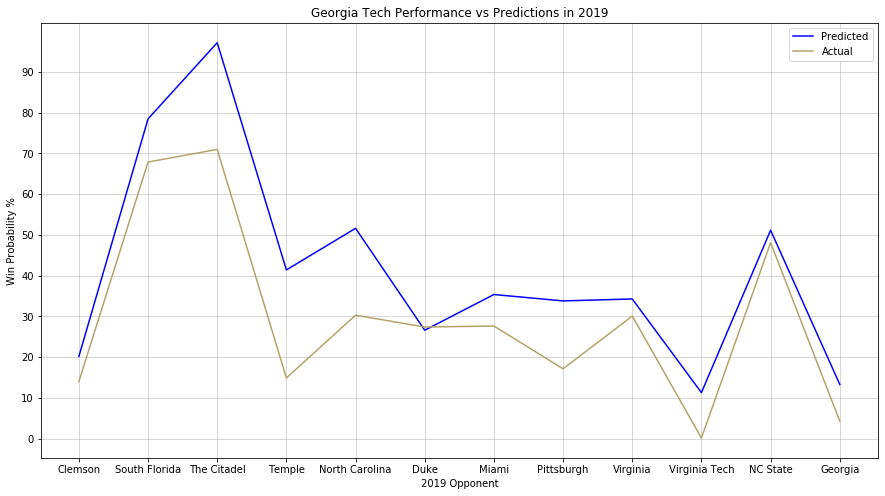

In [54]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

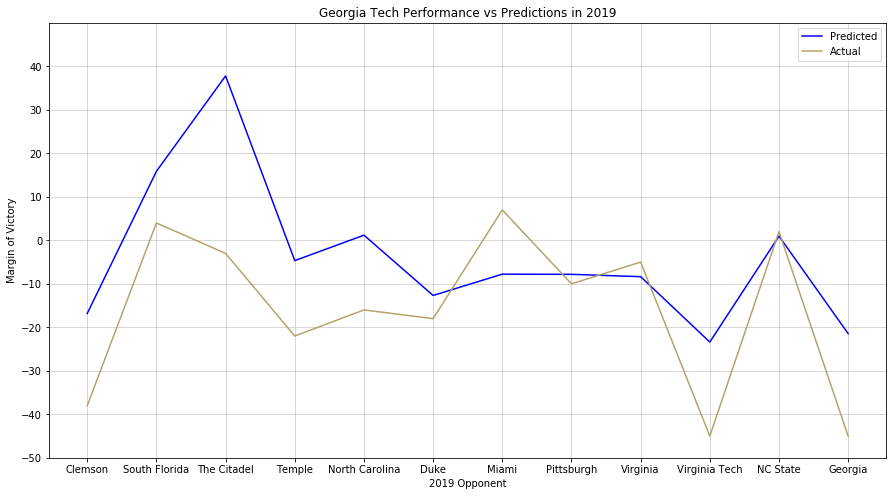

In [55]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 40.0 (exact value: 40.07625900729695)
Z score: 2.0188754078812723
Win Prob for Georgia Tech: 97.82%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 8.0 (exact value: 8.28882950321899)
Z score: 0.4015315017606244
Win Prob for South Florida: 65.60%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 7.0 (exact value: 7.179818806733254)
Z score: 0.3451050552134534
Win Prob for Pittsburgh: 63.50%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 35.0 (exact value: 34.680957004239794)
Z score: 1.7443625280271284
Win Prob for Clemson: 95.95%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 38.0 (exact value: 38.3829250965084)
Z score: 

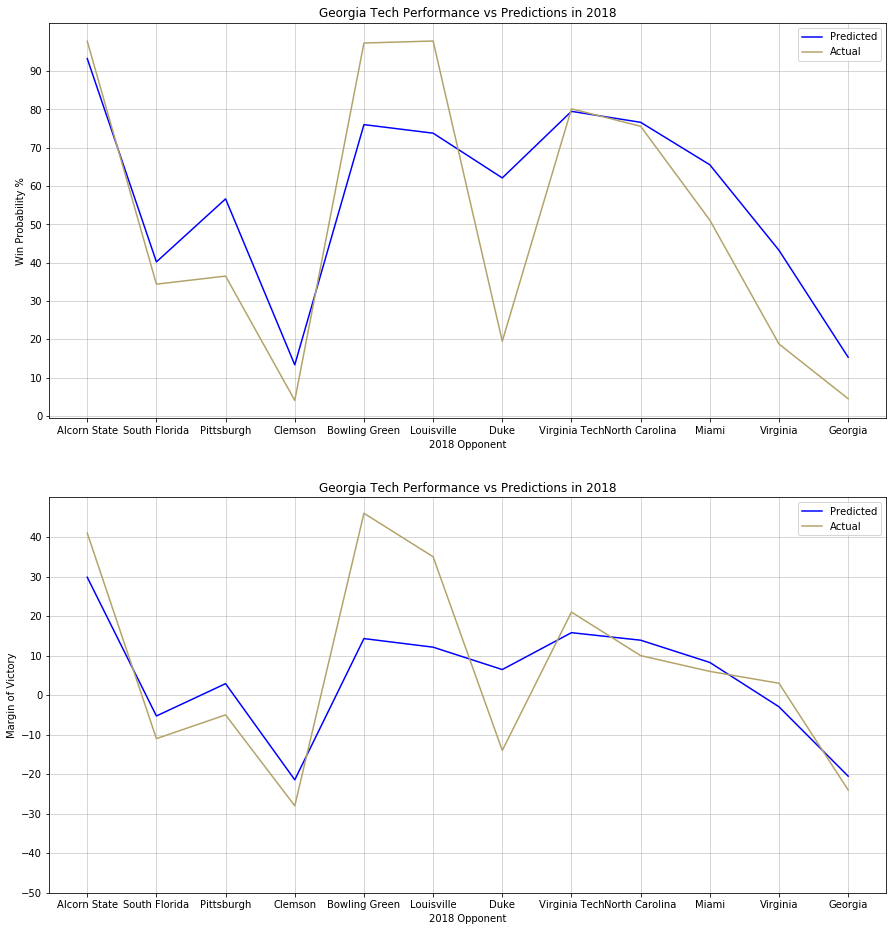

In [56]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

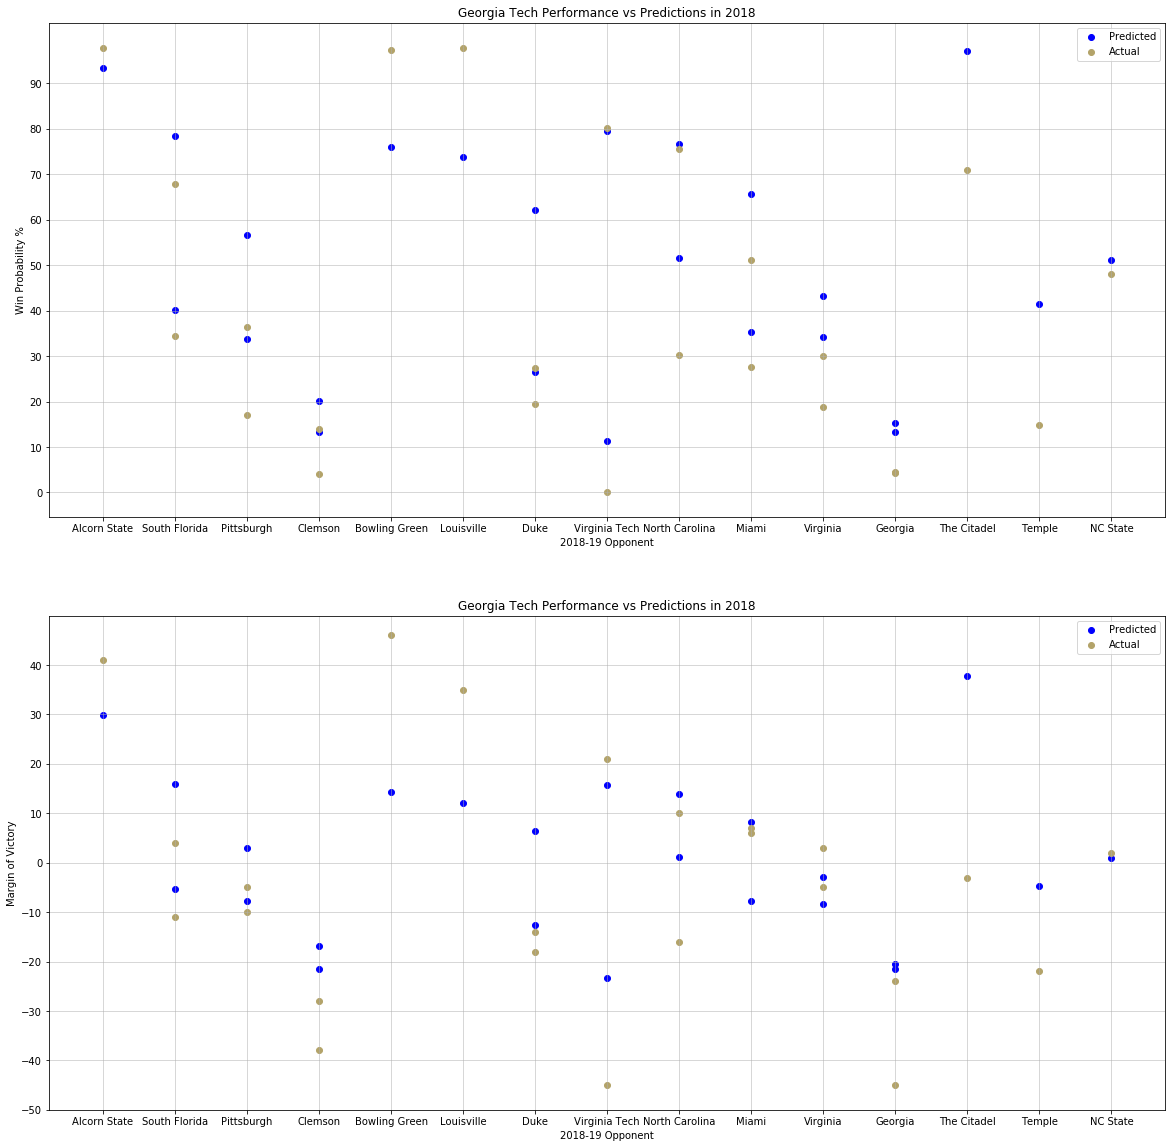

In [57]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [58]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season      2012      2013      2014      2015      2016      2017      2018  \
Season                                                                         
2012    1.000000  0.588419  0.525922  0.451708  0.382888  0.294932  0.300102   
2013    0.588419  1.000000  0.562660  0.366535  0.245886  0.260429  0.185906   
2014    0.525922  0.562660  1.000000  0.616191  0.486516  0.332863  0.332074   
2015    0.451708  0.366535  0.616191  1.000000  0.656791  0.472449  0.379352   
2016    0.382888  0.245886  0.486516  0.656791  1.000000  0.602822  0.417091   
2017    0.294932  0.260429  0.332863  0.472449  0.602822  1.000000  0.634953   
2018    0.300102  0.185906  0.332074  0.379352  0.417091  0.634953  1.000000   
2019    0.363724  0.279529  0.386088  0.403569  0.594267  0.569375  0.610008   

Season      2019  
Season            
2012    0.363724  
2013    0.279529  
2014    0.386088  
2015    0.403569  
2016    0.594267  
2017    0.569375  
2018    0.610008  
2019    1.000000

In [59]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

Year            Team        Opponent  Site  PredWinProb    PredMOV
0   2020  North Carolina             UCF  Away    36.304629  -6.488287
1   2020  North Carolina          Auburn  Home    29.100226 -10.421683
2   2020  North Carolina   James Madison  Home    97.614941  39.312609
3   2020  North Carolina     Connecticut  Home    74.484459  13.336439
4   2020  North Carolina  Boston College  Away    45.489407  -1.829831
5   2020  North Carolina            Duke  Away    47.982877  -0.597078
6   2020  North Carolina           Miami  Away    37.206447  -6.017818
7   2020  North Carolina    Georgia Tech  Home    59.312551   5.027446
8   2020  North Carolina        NC State  Home    55.497591   3.114137
9   2020  North Carolina      Pittsburgh  Home    47.656020  -0.758347
10  2020  North Carolina   Virginia Tech  Home    36.530987  -6.369838
11  2020  North Carolina        Virginia  Away    36.899623  -6.177459

In [60]:
generate_win_prob(401135288, 2019)
box2 = calculate_box_score(401135288, 2019)
# testDiffs = ["Team",'5FRDiff']
# print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API
Game: Oregon @ Wisconsin
Actual Winner: Oregon
MOV: Oregon by 1
Proj MOV: Oregon by 4.0 (exact value: 4.079574401512163)
Z score: 0.1873646693283442
Win Prob for Oregon: 57.43%
---
Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API


Team       Eff      Expl   FinDrv    FldPos   Trnovr       5FR  \
0     Oregon  5.114379  4.961943  4.87236  5.115385  5.68268  5.089276   
1  Wisconsin  4.885621  5.038057  5.12764  4.884615  4.31732  4.910724   

    5FRDiff  
0  0.178552  
1 -0.178552

In [61]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

[0.40620054229344527, -4.267407182047845]

In [62]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [63]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [64]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 700 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 692 games with betting lines for 2013 season.
[Simulation] Creating projections for 692 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 697 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 648 games with betting lines for 2014 season.
[Simulation] Creating projections for 648 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 709 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 675 games with betting lines for 2015 season.
[Simulation] Creating projections for 675 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

pick_category  season    W    L   D    WinPct
0            ML    2013  547  145   0  0.790462
1           ATS    2013  390  294   8  0.563584
0            ML    2014  504  144   0  0.777778
1           ATS    2014  418  214  16  0.645062
0            ML    2015  531  144   0  0.786667
1           ATS    2015  407  250  18  0.602963
0            ML    2016  524  152   0  0.775148
1           ATS    2016  411  247  18  0.607988
0            ML    2017  576  144   0  0.800000
1           ATS    2017  427  273  20  0.593056
0            ML    2018  516  154   0  0.770149
1           ATS    2018  394  259  17  0.588060
0            ML    2019  569  163   0  0.777322
1           ATS    2019  434  287  11  0.592896

In [90]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
print(f"Total earnings (2013-2019) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2019) if betting $10 per game: $8746.0


pick_category  season    W    L   D    WinPct  total_invested  net_payout  \
1           ATS    2013  390  294   8  0.563584            6920       666.0   
1           ATS    2014  418  214  16  0.645062            6480      1826.0   
1           ATS    2015  407  250  18  0.602963            6750      1320.0   
1           ATS    2016  411  247  18  0.607988            6760      1393.0   
1           ATS    2017  427  273  20  0.593056            7200      1267.0   
1           ATS    2018  394  259  17  0.588060            6700      1091.0   
1           ATS    2019  434  287  11  0.592896            7320      1183.0   

   avg_weekly_payout  
1          41.625000  
1         114.125000  
1          88.000000  
1          92.866667  
1          84.466667  
1          72.733333  
1          78.866667

In [65]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7825037798981601
Avg ATS Win %: 0.599086871996983


In [66]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [67]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.5025655799937534, 0.5234870121528845]

In [68]:
generate_win_prob(401135295, 2019)

Could not find basic game data for game_id 401135295 locally, checking CFB Data API
Could not find drive data for game_id 401135295 locally, checking CFB Data API
Could not find play by play data for game_id 401135295 locally, checking CFB Data API
Game: Clemson @ LSU
Actual Winner: LSU
MOV: LSU by 17
Proj MOV: LSU by 14.0 (exact value: 13.590790329386673)
Z score: 0.671295184023533
Win Prob for LSU: 74.90%
---


[0.7489837489721107, 17]